# Identifiez les causes d'attrition au sein d'une ESN

## Analyse exploratoire des données

L’objectif de cette analyse exploratoire est de :
- comprendre la structure et le contenu des jeux de données fournis ;
- identifier les différences potentielles entre les employés ayant quitté l’entreprise et les autres ;
- préparer un jeu de données consolidé et exploitable pour les étapes de modélisation.

### Chargement des jeux de données

Les données utilisées dans ce projet proviennent de trois fichiers distincts :
- **extrait_sirh.csv** : informations générales sur les employés ;
- **extrait_eval.csv** : informations liées évaluations annuelles de performance ;
- **extrait_sondage.csv** : sondage interne.

Chaque fichier est chargé séparément afin d’en analyser la structure avant toute jointure.

In [1]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Custom imports
import data_utils as du
import preprocessing as pp
import visualizer as vi
from redundancy_analysis import full_analysis

PALETTE_TARGET={'Non': '#2ecc71', 'Oui': '#e74c3c'}

df_sirh, df_eval, df_sondage = pp.load_data('data/extrait_sirh.csv', 'data/extrait_eval.csv', 'data/extrait_sondage.csv')

📁 Chargement des données...
   ✓ SIRH: (1470, 12)
   ✓ Évaluations: (1470, 10)
   ✓ Sondage: (1470, 12)


### Aperçu et structure des jeux de données

#### Fichier SIRH

In [2]:
du.explore_dataframe(df_sirh, False)

📋 INFORMATIONS GÉNÉRALES
• Lignes    : 1470
• Colonnes : 12

--- INFO ---
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   id_employee                     1470 non-null   int64
 1   age                             1470 non-null   int64
 2   genre                           1470 non-null   str  
 3   revenu_mensuel                  1470 non-null   int64
 4   statut_marital                  1470 non-null   str  
 5   departement                     1470 non-null   str  
 6   poste                           1470 non-null   str  
 7   nombre_experiences_precedentes  1470 non-null   int64
 8   nombre_heures_travailless       1470 non-null   int64
 9   annee_experience_totale         1470 non-null   int64
 10  annees_dans_l_entreprise        1470 non-null   int64
 11  annees_dans_le_poste_actuel     1470 non-null   int64
dtyp

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000
mean,1024.865306,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252
std,602.024335,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137
min,1.000000,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000
25%,491.250000,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000
50%,1020.500000,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000
75%,1555.750000,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000
max,2068.000000,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000



--- MISSING VALUES ---

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

=== CLASSIFICATION DES VARIABLES ===
QUANTITATIVE (6): ['age', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'id_employee', 'revenu_mensuel']
QUALITATIVE  (4): ['departement', 'genre', 'poste', 'statut_marital']
ORDINAL      (2): ['nombre_experiences_precedentes', 'nombre_heures_travailless']
DATETIME     (0): []
DROP         (0): []

=== DUPLICATES ===
Lignes totales  : 1470
Lignes dupliquées: 0
Taux            : 0.00%


In [3]:
display(df_sirh.head())

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


**Observations principales du fichier SIRH**

Informations générales:
- Nombre de lignes: 1470
- Nombre de colonnes: 12
- Aucune donnée manquante détectée
- Aucun doublon détecté

**Variables**
- `id_employee` : Identifiant unique de l’employé  
  - Variable technique (à exclure des modèles prédictifs)
  - Peut-être utile pour la jointure

- `age` : Âge de l’employé  
  - Variable numérique continue

- `genre` : Sexe de l’employé  
  - Variable catégorielle binaire (F/M)  
  - À encoder (ex. encodage binaire)

- `revenu_mensuel` : Salaire mensuel  
  - Forte dispersion des valeurs  
  - Minimum : 1 009, Maximum : 19 999  
  - À analyser (outliers, normalisation éventuelle)

- `statut_marital` : Situation familiale  
  - Variable catégorielle  
  - À vérifier pour l’encodage

- `departement` : Département / division de l’entreprise  
  - Variable catégorielle  
  - À encoder

- `poste` : Intitulé du poste occupé  
  - Variable catégorielle  
  - Forte cardinalité possible → à surveiller pour l’encodage

- `nombre_experiences_precedentes` : Nombre d’entreprises dans lesquelles l’employé a travaillé auparavant  
  - Variable numérique discrète

- `nombre_heures_travaillees` : Nombre d’heures travaillées  
  - Valeur identique pour tous les employés (80)  
  - Variable non informative → à supprimer

- `annee_experience_totale` : Nombre total d’années d’expérience professionnelle  
  - Variable numérique continue

- `annees_dans_l_entreprise` : Ancienneté dans l’entreprise actuelle  
  - Variable numérique continue

- `annees_dans_le_poste_actuel` : Ancienneté dans le poste actuel  
  - Variable numérique continue


#### Fichier Évaluations

In [4]:
du.explore_dataframe(df_eval, False)

📋 INFORMATIONS GÉNÉRALES
• Lignes    : 1470
• Colonnes : 10

--- INFO ---
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   satisfaction_employee_environnement        1470 non-null   int64
 1   note_evaluation_precedente                 1470 non-null   int64
 2   niveau_hierarchique_poste                  1470 non-null   int64
 3   satisfaction_employee_nature_travail       1470 non-null   int64
 4   satisfaction_employee_equipe               1470 non-null   int64
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64
 6   eval_number                                1470 non-null   str  
 7   note_evaluation_actuelle                   1470 non-null   int64
 8   heure_supplementaires                      1470 non-null   str  
 9   augementation_salaire_precedente           1470 non-nul

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741
std,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000
50%,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000
max,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000



--- MISSING VALUES ---

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

=== CLASSIFICATION DES VARIABLES ===
QUANTITATIVE (0): []
QUALITATIVE  (3): ['augementation_salaire_precedente', 'eval_number', 'heure_supplementaires']
ORDINAL      (7): ['niveau_hierarchique_poste', 'note_evaluation_actuelle', 'note_evaluation_precedente', 'satisfaction_employee_environnement', 'satisfaction_employee_equilibre_pro_perso', 'satisfaction_employee_equipe', 'satisfaction_employee_nature_travail']
DATETIME     (0): []
DROP         (0): []

=== DUPLICATES ===
Lignes totales  : 1470
Lignes dupliquées: 0
Taux            : 0.00%


In [5]:
display(df_eval.head())

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


**Observations principales du fichier eval:**
- Nombre de lignes: 1470
- Nombre de colonnes: 10
- Aucune donnée manquante détectée  
- Aucune donnée aberrante apparente
- Aucun doublon détecté

**Variables :**

- `eval_number` : Identifiant unique de l’évaluation  
  - Format : `E_X` où `X` est un nombre  
  - Variable technique (à exclure des modèles prédictifs)
  - Semble être la variable unique

- `satisfaction_employee_environnement` : Niveau de satisfaction de l’employé concernant son environnement de travail  
  - Variable numérique ordinale  
  - À vérifier (échelle de type Likert)

- `satisfaction_employee_nature_travail` : Niveau de satisfaction concernant la nature et le contenu du travail  
  - Variable numérique ordinale

- `satisfaction_employee_equipe` : Niveau de satisfaction concernant l’équipe et les collègues  
  - Variable numérique ordinale

- `satisfaction_employee_equilibre_pro_perso` : Niveau de satisfaction concernant l’équilibre vie professionnelle / vie personnelle  
  - Variable numérique ordinale

- `note_evaluation_precedente` : Note obtenue lors de l’évaluation annuelle précédente  
  - Variable numérique  
  - À analyser en lien avec la performance actuelle

- `note_evaluation_actuelle` : Note obtenue lors de l’évaluation annuelle actuelle  
  - Variable numérique  
  - Variable cible potentielle selon l’objectif de l’analyse

- `niveau_hierarchique_poste` : Niveau hiérarchique du poste occupé  
  - Variable numérique ordinale  
  - À vérifier (ordre et distribution des niveaux)

- `heure_supplementaires` : Indique si l’employé effectue des heures supplémentaires  
  - Variable catégorielle binaire (Oui/Non)  
  - À encoder

- `augementation_salaire_precedente` : Pourcentage d’augmentation salariale lors du dernier cycle  
  - Variable numérique continue  
  - À analyser (dispersion, valeurs extrêmes éventuelles)
  - Colonne mal orthographiée : devrait être `augmentation_salaire_precedente`


#### Fichier Sondage

In [6]:
du.explore_dataframe(df_sondage, False)

📋 INFORMATIONS GÉNÉRALES
• Lignes    : 1470
• Colonnes : 12

--- INFO ---
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   a_quitte_l_entreprise                1470 non-null   str  
 1   nombre_participation_pee             1470 non-null   int64
 2   nb_formations_suivies                1470 non-null   int64
 3   nombre_employee_sous_responsabilite  1470 non-null   int64
 4   code_sondage                         1470 non-null   int64
 5   distance_domicile_travail            1470 non-null   int64
 6   niveau_education                     1470 non-null   int64
 7   domaine_etude                        1470 non-null   str  
 8   ayant_enfants                        1470 non-null   str  
 9   frequence_deplacement                1470 non-null   str  
 10  annees_depuis_la_derniere_promotion  1470 non-null   int6

,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.793878,2.799320,1.0,1024.865306,9.192517,2.912925,2.187755,4.123129
std,0.852077,1.289271,0.0,602.024335,8.106864,1.024165,3.222430,3.568136
min,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.0,491.250000,2.000000,2.000000,0.000000,2.000000
50%,1.000000,3.000000,1.0,1020.500000,7.000000,3.000000,1.000000,3.000000
75%,1.000000,3.000000,1.0,1555.750000,14.000000,4.000000,3.000000,7.000000
max,3.000000,6.000000,1.0,2068.000000,29.000000,5.000000,15.000000,17.000000



--- MISSING VALUES ---

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

=== CLASSIFICATION DES VARIABLES ===
QUANTITATIVE (4): ['annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'code_sondage', 'distance_domicile_travail']
QUALITATIVE  (4): ['a_quitte_l_entreprise', 'ayant_enfants', 'domaine_etude', 'frequence_deplacement']
ORDINAL      (4): ['nb_formations_suivies', 'niveau_education', 'nombre_employee_sous_responsabilite', 'nombre_participation_pee']
DATETIME     (0): []
DROP         (0): []

=== DUPLICATES ===
Lignes totales  : 1470
Lignes dupliquées: 0
Taux            : 0.00%


In [7]:
display(df_sondage.head())

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


**Observations principales du fichier sondage :**
- Nombre de lignes : 1470
- Nombre de colonnes : 12
- Aucune donnée manquante détectée  
- Aucune donnée aberrante apparente
- Aucun doublon détecté

**Variables :**

- `a_quitte_l_entreprise` : Indique si l’employé a quitté l’entreprise  
  - Variable catégorielle binaire (Oui/Non)  
  - **Variable cible** de l’étude

- `nombre_participation_pee` : Nombre de participations au Plan d’Épargne Entreprise (PEE)  
  - Variable numérique discrète  
  - Potentiel indicateur d’engagement à long terme

- `nb_formations_suivies` : Nombre de formations suivies au cours de l’année  
  - Variable numérique discrète  
  - À analyser en lien avec le développement des compétences

- `nombre_employee_sous_responsabilite` : Nombre d’employés sous la responsabilité directe  
  - Variable numérique discrète  
  - Peut refléter le niveau de responsabilité managériale

- `code_sondage` : Identifiant unique du sondage  
  - Variable technique  
  - À exclure des modèles prédictifs

- `distance_domicile_travail` : Distance (en kilomètres) entre le domicile et le lieu de travail  
  - Variable numérique continue  
  - À analyser (impact potentiel sur le turnover)

- `niveau_education` : Niveau d’études atteint par l’employé  
  - Variable catégorielle ordinale  
  - À vérifier (ordre et encodage)

- `domaine_etude` : Domaine d’études ou spécialisation  
  - Variable catégorielle nominale  
  - À encoder

- `ayant_enfants` : Indique si l’employé a des enfants  
  - Variable catégorielle binaire  
  - À vérifier (faible variabilité possible)

- `frequence_deplacement` : Fréquence des déplacements professionnels  
  - Variable catégorielle ordinale  
  - À encoder selon une hiérarchie pertinente

- `annees_depuis_la_derniere_promotion` : Nombre d’années écoulées depuis la dernière promotion  
  - Variable numérique discrète  
  - Indicateur potentiel de stagnation professionnelle

- `annes_sous_responsable_actuel` : Nombre d’années sous la responsabilité du manager actuel  
  - Variable numérique discrète  
  - À analyser en lien avec la stabilité managériale
  - Colonne mal orthographiée : devrait être `annees_sous_responsabilite_actuelle`

### Identification de la variable cible

Notre variable cible est : `a_quitte_l_entreprise`.  
C’est la seule variable qui indique si un employé est présent ou non dans l’entreprise.

In [8]:
TARGET = 'a_quitte_l_entreprise'


📊 Distribution de la colonne 'a_quitte_l_entreprise'
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
a_quitte_l_entreprise,,
Non,1233,83.88
Oui,237,16.12


Ratio de déséquilibre : 5.2:1 (1233 vs 237)


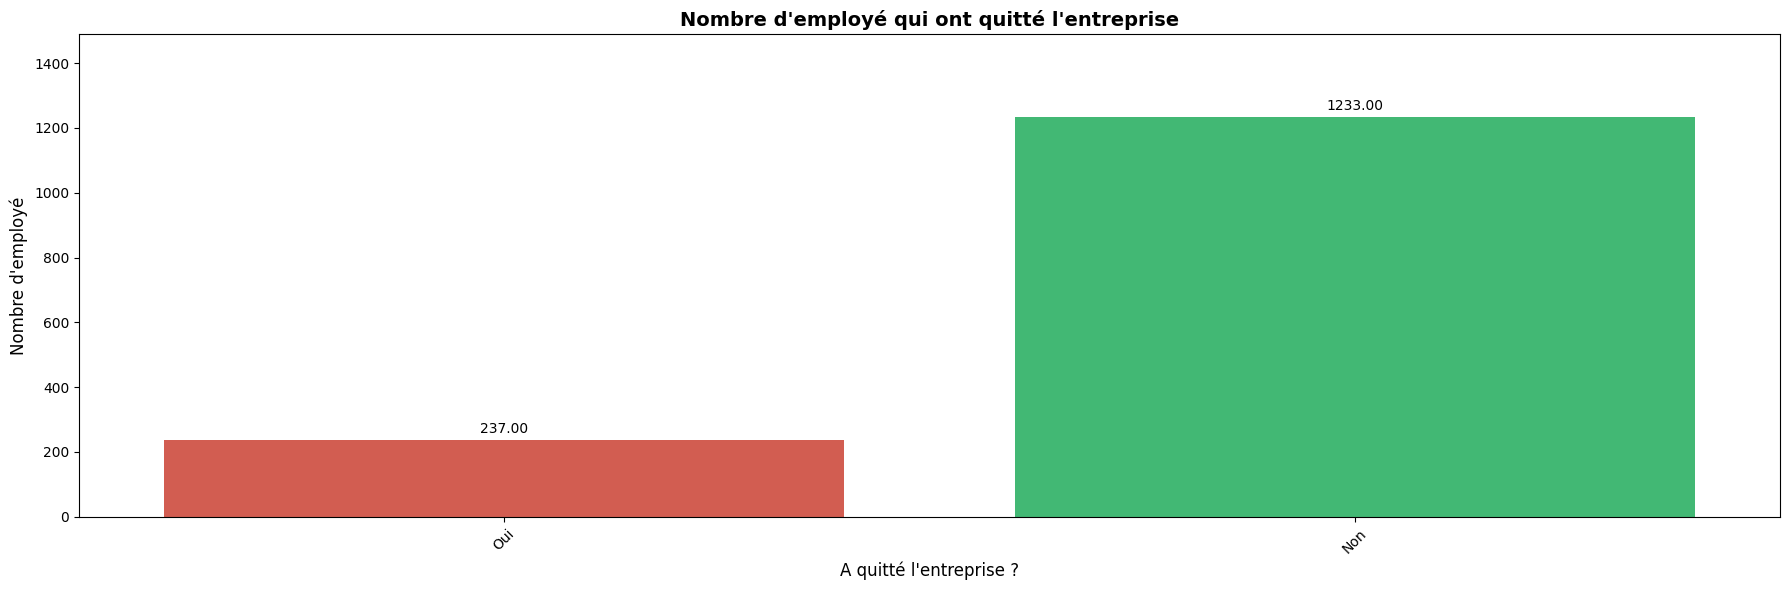

In [9]:
du.distribution_column(df_sondage, TARGET)

n_maj = df_sondage[TARGET].value_counts()['Non']
n_min = df_sondage[TARGET].value_counts()['Oui']
ratio = n_maj / n_min
print(f"Ratio de déséquilibre : {ratio:.1f}:1 ({n_maj} vs {n_min})")


fig, axes = plt.subplots(1, 1, figsize=(18, 6))
vi.create_barplot(
	df_sondage,
    axes,
    TARGET,
	hue=TARGET,
    title="Nombre d'employé qui ont quitté l'entreprise",
    xlabel="A quitté l'entreprise ?",
    ylabel="Nombre d'employé",
	palette=PALETTE_TARGET,
)
plt.tight_layout()
plt.show()


Le taux d’attrition s’élève à **16 %**. On constate également un déséquilibre marqué des classes (**ratio ≈ 5,2:1**), qui devra être traité lors de la modélisation afin de prévenir un biais en faveur de la classe dominante.

### Nettoyage et préparation des fichiers sources

Avant de réaliser les analyses, un nettoyage préliminaire est effectué afin de :
- corriger ou transformer certaines variables ;
- homogénéiser les types de données ;
- faciliter les jointures entre fichiers.


#### Nettoyage du fichier SIRH

In [10]:
du.display_single_column_info(df_sirh, 'genre', True)

┌─ genre
│
│  🔤 Type: str
│  🎯 Uniques: 2 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: F, M
│


,Effectif,Pourcentage
genre,,
M,882,60.0
F,588,40.0


└──────────────────────────────────────────────────────────────────────────────



La colonne **genre** est une variable catégorielle binaire (`F` / `M`).  
La répartition montre une proportion plus élevée d’hommes que de femmes.  
Aucun traitement de nettoyage n’est nécessaire.

In [11]:
du.display_single_column_info(df_sirh,'statut_marital', True)

┌─ statut_marital
│
│  🔤 Type: str
│  🎯 Uniques: 3 (0.2%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Célibataire, Marié(e), Divorcé(e)
│


,Effectif,Pourcentage
statut_marital,,
Marié(e),673,45.78
Célibataire,470,31.97
Divorcé(e),327,22.24


└──────────────────────────────────────────────────────────────────────────────



La colonne **statut_marital** est une variable catégorielle (`Célibataire`, `Divorcé(e)`, `Marié(e)`).
On constate que l'entreprise a employé davantage de personne mariés.

Aucun traitement de nettoyage n’est nécessaire.

In [12]:
du.display_single_column_info(df_sirh,'departement', True)

┌─ departement
│
│  🔤 Type: str
│  🎯 Uniques: 3 (0.2%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Commercial, Consulting, Ressources Humaines
│


,Effectif,Pourcentage
departement,,
Consulting,961,65.37
Commercial,446,30.34
Ressources Humaines,63,4.29


└──────────────────────────────────────────────────────────────────────────────



La colonne **departement** est une variable catégorielle contenant 3 valeurs (`Consulting`, `Commercial`, `Ressources Humaines`).

Aucun traitement de nettoyage n’est nécessaire.

In [13]:
du.display_single_column_info(df_sirh,'poste', True)

┌─ poste
│
│  🔤 Type: str
│  🎯 Uniques: 9 (0.6%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Cadre Commercial, Assistant de Direction, Consultant, Tech L...
│


,Effectif,Pourcentage
poste,,
Cadre Commercial,326,22.18
Assistant de Direction,292,19.86
Consultant,259,17.62
Tech Lead,145,9.86
Manager,131,8.91
Senior Manager,102,6.94
Représentant Commercial,83,5.65
Directeur Technique,80,5.44
Ressources Humaines,52,3.54


└──────────────────────────────────────────────────────────────────────────────



La colonne **poste** est une variable catégorielle contenant 9 valeurs uniques.

Aucun traitement de nettoyage n’est nécessaire.

In [14]:
du.display_single_column_info(df_sirh,'nombre_heures_travailless')

┌─ nombre_heures_travailless
│
│  🔢 Type: int64
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 80
└──────────────────────────────────────────────────────────────────────────────



La colonne **nombre_heures_travaillées** ne contient qu’une seule valeur unique ; elle n’apporte donc aucune information prédictive et sera donc supprimée.

In [15]:
df_sirh_clean = pp.clean_sirh_data(df_sirh)


🧹 Nettoyage du fichier SIRH...
🗂️ Suppression de colonnes | shape initiale : (1470, 12)
✅ 1 colonne supprimée | 0 inexistante | shape finale : (1470, 11)
   ✓ Nettoyage terminé. Nouvelles dimensions: (1470, 11)


#### Nettoyage du fichier Évaluations 

In [16]:
du.display_single_column_info(df_eval, 'eval_number')


┌─ eval_number
│
│  🔤 Type: str
│  🎯 Uniques: 1,470 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────



La colonne **eval_number** semble être un identifiant unique pour chaque employé, formaté comme `E_X` où `X` est l'ID numérique de l'employé.
Pour cela nous allons la nettoyer  afin d'extraire l'ID numérique et la faire correspondre avec la colonne **id_employee** du fichier SIRH.

In [17]:
du.display_single_column_info(df_eval, 'augementation_salaire_precedente')


┌─ augementation_salaire_precedente
│
│  🔤 Type: str
│  🎯 Uniques: 15 (1.0%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────



La colonne **augementation_salaire_precedente** contient des pourcentages sous forme de chaînes de caractères (ex. : `5 %`).  
Ces valeurs doivent être converties en format numérique afin de pouvoir être exploitées dans les analyses et les modèles.  
Par ailleurs, le nom de la colonne est mal orthographié : elle sera renommée en **augmentation_salaire_precedente**.


In [18]:
du.display_single_column_info(df_eval, 'note_evaluation_actuelle')
du.distribution_column(df_eval, 'note_evaluation_actuelle')
du.distribution_column(df_eval, 'note_evaluation_precedente')


┌─ note_evaluation_actuelle
│
│  🔢 Type: int64
│  🎯 Uniques: 2 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 3, 4
└──────────────────────────────────────────────────────────────────────────────


📊 Distribution de la colonne 'note_evaluation_actuelle'
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
note_evaluation_actuelle,,
3,1244,84.63
4,226,15.37



📊 Distribution de la colonne 'note_evaluation_precedente'
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
note_evaluation_precedente,,
3,868,59.05
2,375,25.51
4,144,9.80
1,83,5.65


La colonne **note_evaluation_actuelle** présente une variabilité très limitée, ce qui soulève un doute légitime quant à sa capacité prédictive. 

Cette distribution peut s’expliquer par un biais de sélection (départ des salariés faiblement notés), un effet de normalisation des évaluations ou une amélioration globale des performances.

Une analyse croisée avec la variable cible ainsi qu’une étude de l’évolution des notes individuelles sont nécessaires avant de statuer sur son caractère informatif. À défaut, cette variable pourra être écartée ou transformée en indicateur d’évolution

In [19]:
df_eval_clean = pp.clean_eval_data(df_eval)


🧹 Nettoyage du fichier des évaluations...
🗂️ Suppression de colonnes | shape initiale : (1470, 12)
✅ 2 colonnes supprimées | 0 inexistante | shape finale : (1470, 10)
   ✓ Nettoyage terminé. Nouvelles dimensions: (1470, 10)


#### Nettoyage du fichier Sondage

In [20]:
du.display_single_column_info(df_sondage, 'code_sondage')


┌─ code_sondage
│
│  🔢 Type: int64
│  🎯 Uniques: 1,470 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 1.00 | Max: 2068.00 | Moyenne: 1024.87
└──────────────────────────────────────────────────────────────────────────────



La colonne **`code_sondage`** contient uniquement des valeurs uniques.  
Il s’agit d’un identifiant technique utilisé pour la jointure avec le SIRH et ne présentant aucune valeur prédictive.


In [21]:
du.display_single_column_info(df_sondage, 'nombre_employee_sous_responsabilite')


┌─ nombre_employee_sous_responsabilite
│
│  🔢 Type: int64
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 1
└──────────────────────────────────────────────────────────────────────────────



La colonne **nombre_employee_sous_responsabilite** ne contient qu’une seule valeur unique ; elle n’apporte donc aucune information prédictive et sera donc supprimée.

In [22]:
du.display_single_column_info(df_sondage, 'ayant_enfants', True)


┌─ ayant_enfants
│
│  🔤 Type: str
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Y
│


,Effectif,Pourcentage
ayant_enfants,,
Y,1470,100.0


└──────────────────────────────────────────────────────────────────────────────



La colonne **`ayant_enfants`** ne contient qu’une seule valeur unique.  
Cela signifie que, dans ce jeu de données, toutes les personnes qui sont ou ont été employées ont des enfants, ou bien qu’il s’agit d’une erreur dans les données.  
Par conséquent, cette variable n’apporte aucune information discriminante ni valeur prédictive pour le modèle et sera donc supprimée.



In [23]:
df_sondage_clean = pp.clean_sondage_data(df_sondage)


🧹 Nettoyage du fichier des sondages...
🗂️ Suppression de colonnes | shape initiale : (1470, 13)
✅ 3 colonnes supprimées | 0 inexistante | shape finale : (1470, 10)
   ✓ Nettoyage terminé. Nouvelles dimensions: (1470, 10)


### Fusion des jeux de données

Les trois jeux de données sont fusionnés afin d’obtenir une vue consolidée par employé.

Lors de la phase de nettoyage, les identifiants des employés ont été harmonisés afin de garantir la cohérence et la fiabilité des jointures entre les différentes sources.

Dans le cadre de la modélisation, il est nécessaire de regrouper l’ensemble de ces informations au sein d’un **DataFrame unique**.  
Chaque jeu de données dispose de son propre identifiant unique :

- `id_employee` pour `extrait_sirh`
- `eval_number` pour `extrait_eval`
- `code_sondage` pour `extrait_sondage`

La prochaine étape consiste à vérifier l’existence d’un lien exploitable entre ces identifiants afin de permettre la fusion des jeux de données.


In [24]:
du.display_single_column_info(df_sirh_clean, 'id_employee')
du.display_single_column_info(df_eval_clean, 'employee_id_extracted')
du.display_single_column_info(df_sondage_clean, 'code_sondage')

┌─ id_employee
│
│  🔢 Type: int64
│  🎯 Uniques: 1,470 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 1.00 | Max: 2068.00 | Moyenne: 1024.87
└──────────────────────────────────────────────────────────────────────────────

┌─ employee_id_extracted
│
│  🔢 Type: int64
│  🎯 Uniques: 1,470 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 1.00 | Max: 2068.00 | Moyenne: 1024.87
└──────────────────────────────────────────────────────────────────────────────

┌─ code_sondage
│
│  🔢 Type: int64
│  🎯 Uniques: 1,470 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 1.00 | Max: 2068.00 | Moyenne: 1024.87
└──────────────────────────────────────────────────────────────────────────────



In [25]:
common_ids = set(df_eval_clean['employee_id_extracted']) & set(df_sirh_clean['id_employee'])
print(f"\n   📌 CORRESPONDANCE TROUVÉE:")
print(f"      eval_number (E_X) → id_employee (X)")
print(f"      Exemple: E_1 → 1, E_2 → 2")
print(f"      Employés communs: {len(common_ids)} / {df_eval_clean['employee_id_extracted'].nunique()}")


   📌 CORRESPONDANCE TROUVÉE:
      eval_number (E_X) → id_employee (X)
      Exemple: E_1 → 1, E_2 → 2
      Employés communs: 1470 / 1470


In [26]:
common_ids_sirh_sondage = set(df_sirh_clean['id_employee']) & set(df_sondage_clean['code_sondage'])
print(f"\n   📌 CORRESPONDANCE TROUVÉE:")
print(f"      code_sondage → id_employee (correspondance directe)")
print(f"      Employés communs: {len(common_ids_sirh_sondage)} / {df_sirh_clean['id_employee'].nunique()}")


   📌 CORRESPONDANCE TROUVÉE:
      code_sondage → id_employee (correspondance directe)
      Employés communs: 1470 / 1470


Les trois jeux de données contiennent chacun **1 470 identifiants uniques**, et la vérification préalable montre que ces ensembles d’identifiants sont strictement identiques (1 470 correspondances sur 1 470). Dans ce contexte, une jointure de type `inner`, `left` ou `right` produirait un résultat identique.

Nous optons néanmoins pour une jointure de type `left` par précaution méthodologique : en cas d’évolution des données sources (par exemple, l’ajout de nouveaux employés dans un fichier mais pas dans les autres), cette approche garantit la conservation de l’ensemble des lignes du fichier de référence (SIRH), quitte à introduire des valeurs manquantes afin de les détecter explicitement plutôt que de perdre silencieusement des observations.

Nous supprimerons également la colonne `id_employee`, car elle n’apporte aucune valeur prédictive.

In [27]:
df = pp.fusionner_datasets(df_sirh_clean, df_eval_clean, df_sondage_clean)


🔗 Fusion des datasets...
   • Fusion ÉVALUATIONS ↔ SIRH...
      → Résultat: (1470, 20)
      → Lignes perdues: SIRH=0, EVAL=0
   • Fusion avec SONDAGE...
      → Résultat final: (1470, 29)
      → Lignes perdues: 0

✓ Employés uniques dans le dataset final: 1470
🗂️ Suppression de colonnes | shape initiale : (1470, 29)
✅ 1 colonne supprimée | 0 inexistante | shape finale : (1470, 28)


In [28]:
du.explore_dataframe(df, False)

📋 INFORMATIONS GÉNÉRALES
• Lignes    : 1470
• Colonnes : 28

--- INFO ---
<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        1470 non-null   int64
 1   genre                                      1470 non-null   str  
 2   revenu_mensuel                             1470 non-null   int64
 3   statut_marital                             1470 non-null   str  
 4   departement                                1470 non-null   str  
 5   poste                                      1470 non-null   str  
 6   nombre_experiences_precedentes             1470 non-null   int64
 7   annee_experience_totale                    1470 non-null   int64
 8   annees_dans_l_entreprise                   1470 non-null   int64
 9   annees_dans_le_poste_actuel                1470 non-nul

,age,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,augmentation_salaire_precedente,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,6502.931293,2.693197,11.279592,7.008163,4.229252,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741,15.209524,0.793878,2.799320,9.192517,2.912925,2.187755,4.123129
std,9.135373,4707.956783,2.498009,7.780782,6.126525,3.623137,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824,3.659938,0.852077,1.289271,8.106864,1.024165,3.222430,3.568136
min,18.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,11.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,2911.000000,1.000000,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,12.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000
50%,36.000000,4919.000000,2.000000,10.000000,5.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,14.000000,1.000000,3.000000,7.000000,3.000000,1.000000,3.000000
75%,43.000000,8379.000000,4.000000,15.000000,9.000000,7.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,18.000000,1.000000,3.000000,14.000000,4.000000,3.000000,7.000000
max,60.000000,19999.000000,9.000000,40.000000,40.000000,18.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,25.000000,3.000000,6.000000,29.000000,5.000000,15.000000,17.000000



--- MISSING VALUES ---

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

=== CLASSIFICATION DES VARIABLES ===
QUANTITATIVE (8): ['age', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annees_depuis_la_derniere_promotion', 'annees_sous_responsable_actuel', 'distance_domicile_travail', 'revenu_mensuel']
QUALITATIVE  (8): ['a_quitte_l_entreprise', 'departement', 'domaine_etude', 'frequence_deplacement', 'genre', 'heure_supplementaires', 'poste', 'statut_marital']
ORDINAL      (12): ['augmentation_salaire_precedente', 'nb_formations_suivies', 'niveau_education', 'niveau_hierarchique_poste', 'nombre_experiences_precedentes', 'nombre_participation_pee', 'note_evaluation_actuelle', 'note_evaluation_precedente', 'satisfaction_employee_environnement', 'satisfaction_employee_equilibre_pro_perso', 'satisfaction_employee_equipe', 'satisfaction_employee_nature_travail']
DATETIME     (0): []
DROP         (0): []

=== DUPLICATES ===
Lignes totales

In [29]:
display(df.head())

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,...,augmentation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,...,11,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,...,23,Non,1,3,8,1,Infra & Cloud,Frequent,1,7
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,...,15,Oui,0,3,2,2,Autre,Occasionnel,0,0
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,...,11,Non,0,3,3,4,Infra & Cloud,Frequent,3,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,...,12,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2


#### Récapitulatif du DataFrame central

Le DataFrame consolidé contient **1 470 lignes** et **29 colonnes**, sans valeur manquante et aucun doublon.

##### Colonnes supprimées lors du nettoyage

| Colonne | Source | Motif |
|---|---|---|
| `nombre_heures_travailless` | SIRH | Valeur unique (80) — non informative |
| `nombre_employee_sous_responsabilite` | Sondage | Valeur unique (1) — non informative |
| `ayant_enfants` | Sondage | Valeur unique (Y) — non informative |
| `eval_number` | Évaluations | Remplacée par `employee_id_extracted` après extraction de l'ID |

##### Colonnes techniques (à exclure de la modélisation)

| Colonne | Rôle |
|---|---|
| `id_employee` | Clé de jointure — pas de valeur prédictive |

##### Variable cible

| Colonne | Type | Distribution |
|---|---|---|
| `a_quitte_l_entreprise` | Catégorielle binaire (Oui/Non) | 16 % Oui / 84 % Non — classes déséquilibrées |

##### Variables explicatives conservées (27)

| Type | Variables |
|---|---|
| **Quantitatives continues** | `age`, `revenu_mensuel`, `annee_experience_totale`, `annees_dans_l_entreprise`, `annees_dans_le_poste_actuel`, `distance_domicile_travail`, `augementation_salaire_precedente`, `annees_depuis_la_derniere_promotion`, `annees_sous_responsable_actuel` |
| **Quantitatives discrètes** | `nombre_experiences_precedentes`, `nombre_participation_pee`, `nb_formations_suivies` |
| **Ordinales** (échelle 1-4/5) | `satisfaction_employee_environnement`, `satisfaction_employee_nature_travail`, `satisfaction_employee_equipe`, `satisfaction_employee_equilibre_pro_perso`, `note_evaluation_precedente`, `note_evaluation_actuelle`, `niveau_hierarchique_poste`, `niveau_education` |
| **Catégorielles nominales** | `genre`, `statut_marital`, `departement`, `poste`, `domaine_etude`, `frequence_deplacement`, `heure_supplementaires` |


#### Détection des outliers

Avant d'analyser les distributions, nous identifions les valeurs extrêmes susceptibles d'influencer les analyses statistiques et les modèles de machine learning.

La méthode utilisée est l'**écart interquartile (IQR)** :
- Borne inférieure : Q1 - 1.5 × IQR
- Borne supérieure : Q3 + 1.5 × IQR

Les observations situées au-delà de ces bornes sont considérées comme des outliers.


OUTLIERS : revenu_mensuel
Borne inférieure : -5291.00
Borne supérieure : 16581.00

Nombre d'outliers : 114 sur 1470 (7.8%)


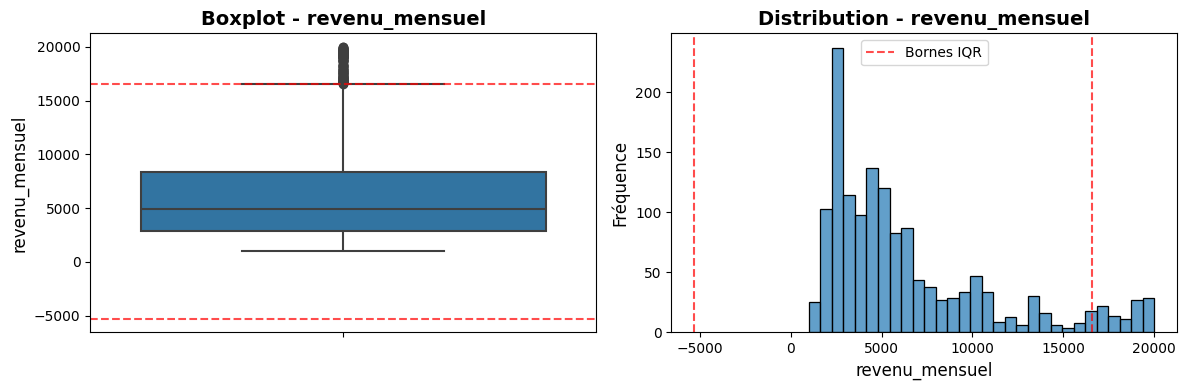

,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel,mobilite_interne,age_debut_carriere,score_satisfaction_global
25,53,0,19094,Divorcé(e),Senior Manager,4,26,13,3,3,3,4,2,3,0,11,Non,1,3,5,3,Autre,1,4,8,1,27,3.00
29,46,0,18947,Célibataire,Senior Manager,3,22,2,2,3,1,4,2,3,0,12,Non,0,2,2,4,Marketing,1,2,1,0,24,2.25
45,41,0,19545,Marié(e),Directeur Technique,1,23,15,2,3,3,4,3,3,0,12,Oui,0,0,12,3,Entrepreunariat,1,15,8,7,18,3.00
62,50,0,18740,Divorcé(e),Directeur Technique,5,29,3,2,2,3,4,2,3,1,12,Non,1,2,7,2,Transformation Digitale,1,13,8,24,21,2.75
105,59,0,18844,Marié(e),Senior Manager,9,30,2,3,2,4,4,3,4,0,21,Non,1,3,2,4,Ressources Humaines,0,2,2,1,29,3.50


In [ ]:
outlier_revenu_mensuel = du.show_outliers(df, 'revenu_mensuel', True)
display(outlier_revenu_mensuel.head(5))

**Observations :**

Les revenus élevés identifiés comme outliers correspondent vraisemblablement à des postes de direction ou de management senior. Cette hypothèse est cohérente avec la forte corrélation observée entre `revenu_mensuel` et `niveau_hierarchique_poste` (ρ = 0.95).

Ces valeurs ne constituent pas des erreurs de saisie mais reflètent la structure salariale de l'entreprise. Elles seront conservées telles quelles dans l'analyse.

### Analyse exploratoire centrée sur l’attrition

Nous allons maintenant comparer les deux populations d'employés :
- Ceux qui ont **quitté** l'entreprise (`Oui`)
- Ceux qui sont **restés** (`Non`)

L'objectif est de faire ressortir des différences clés pouvant expliquer l'attrition.

#### Analyse des variables quantitatives (Partis vs Restés)

a_quitte_l_entreprise,Non,Oui,Écart (%)
annees_dans_le_poste_actuel,4.48,2.90,-35.3
annees_sous_responsable_actuel,4.37,2.85,-34.7
annee_experience_totale,11.86,8.24,-30.5
annees_dans_l_entreprise,7.37,5.13,-30.4
revenu_mensuel,6832.74,4787.09,-29.9
distance_domicile_travail,8.92,10.63,19.3
annees_depuis_la_derniere_promotion,2.23,1.95,-12.9
nombre_experiences_precedentes,2.65,2.94,11.2
age,37.56,33.61,-10.5
augmentation_salaire_precedente,15.23,15.10,-0.9


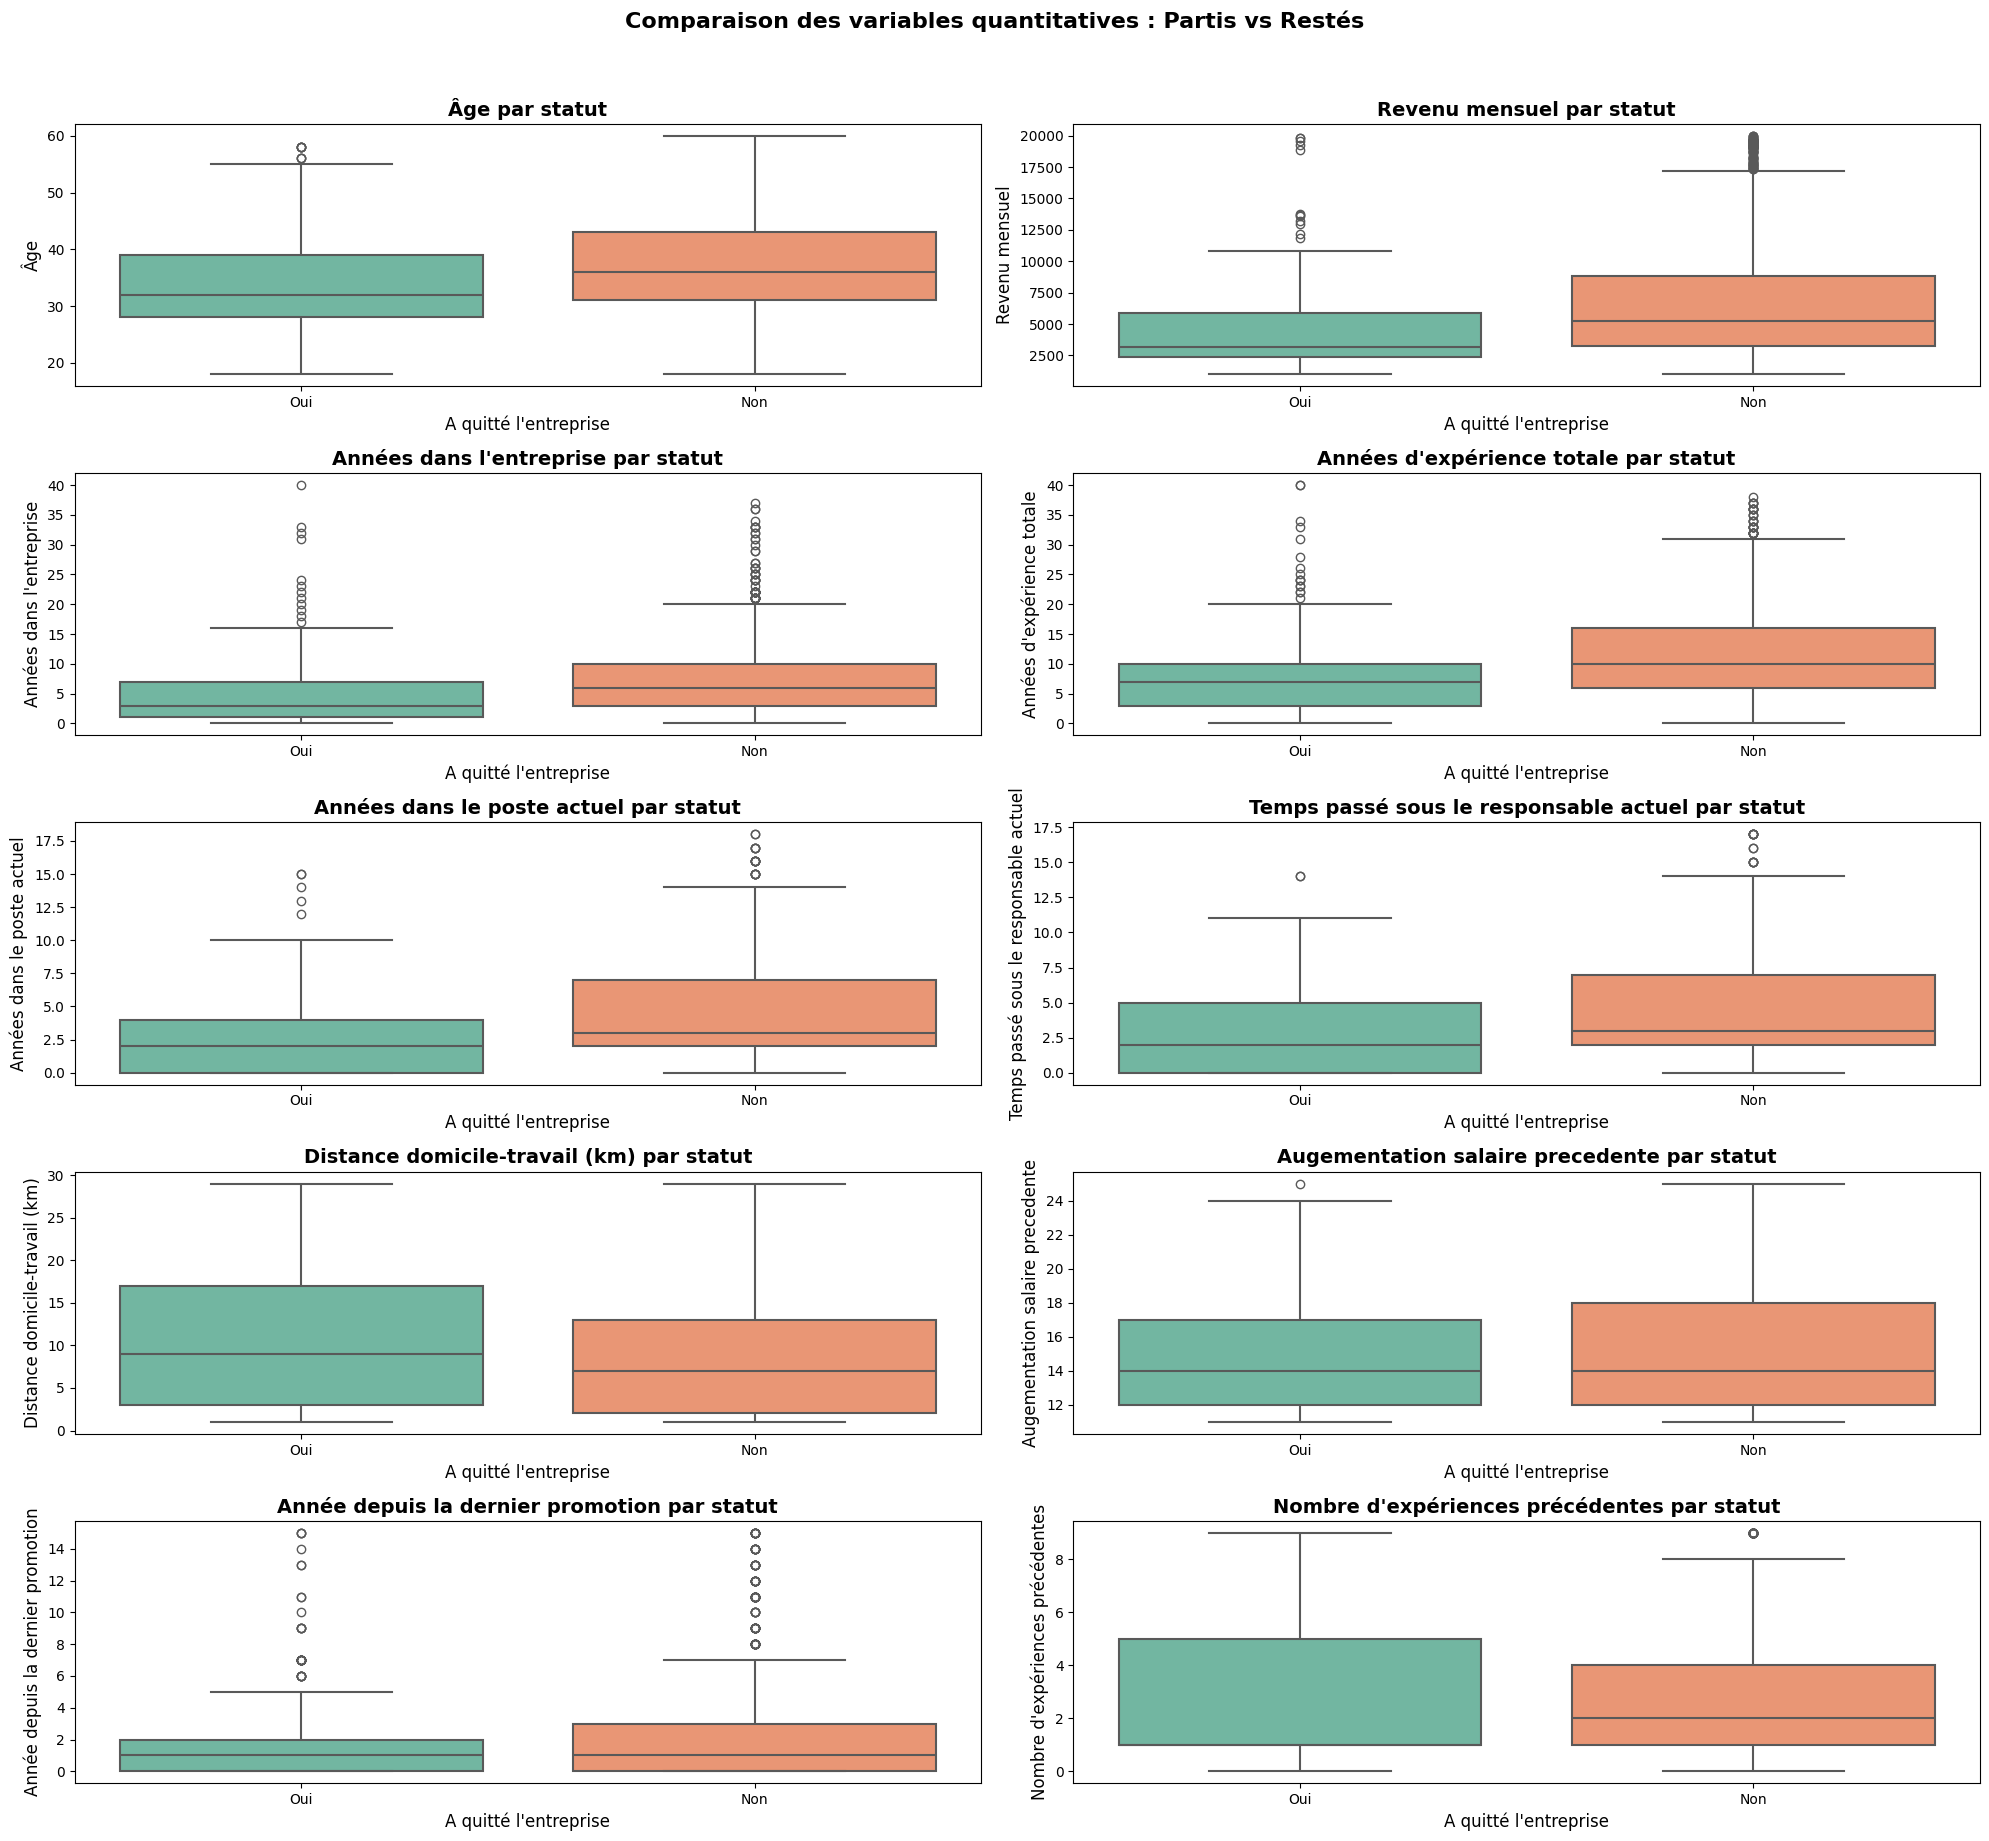

In [31]:
colonnes_quanti = [
    'age', 'revenu_mensuel', 'annee_experience_totale',
    'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
    'distance_domicile_travail', 'augmentation_salaire_precedente',
    'annees_depuis_la_derniere_promotion', 'annees_sous_responsable_actuel',
    'nombre_experiences_precedentes'
]

boxplot_vars = [
    ('age', 'Âge'),
    ('revenu_mensuel', 'Revenu mensuel'),
    ('annees_dans_l_entreprise', "Années dans l'entreprise"),
    ('annee_experience_totale', "Années d'expérience totale"),
    ('annees_dans_le_poste_actuel', 'Années dans le poste actuel'),
    ('annees_sous_responsable_actuel', 'Temps passé sous le responsable actuel'),
    ('distance_domicile_travail', 'Distance domicile-travail (km)'),
    ('augmentation_salaire_precedente', 'Augementation salaire precedente'),
    ('annees_depuis_la_derniere_promotion', 'Année depuis la dernier promotion'),
    ('nombre_experiences_precedentes', "Nombre d'expériences précédentes")
]


df_comparison_quanti_cols = du.compare_group_means(df, TARGET, colonnes_quanti)

display(df_comparison_quanti_cols)

fig, axes = plt.subplots(5,2, figsize=(20, 18))
axes = axes.flatten()

for i, (col, label) in enumerate(boxplot_vars):
    title = f'{label} par statut'
    vi.create_boxplot(
        df,
        axes[i],
        x=TARGET,
        y=col,
        hue=TARGET,
        palette='Set2',
        title=title,
        xlabel="A quitté l'entreprise",
        ylabel=label
    )

plt.suptitle("Comparaison des variables quantitatives : Partis vs Restés", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Observations sur les variables quantitatives :**

L’analyse des variables quantitatives met en évidence des différences notables entre les employés ayant quitté l’entreprise et ceux qui y sont restés.

Les employés partis présentent un **revenu mensuel moyen plus faible** (4 787 € contre 6 833 €, soit un écart de **-29,9 %**), suggérant que la rémunération constitue un facteur important du turnover.

Ils ont également une **ancienneté plus faible**, que ce soit dans l’entreprise (-30,4 %), dans le poste actuel (-35,3 %) ou sous le responsable actuel (-34,7 %). Cela indique que les départs surviennent principalement **au début du parcours professionnel au sein de l’entreprise**, avant une stabilisation complète.

En termes de profil, les employés ayant quitté l’entreprise sont **plus jeunes** (-10,5 %) et disposent de **moins d’expérience totale** (-30,5 %), ce qui confirme une plus forte exposition au départ des profils juniors ou intermédiaires.

Le **nombre d’expériences professionnelles précédentes** est légèrement plus élevé chez les employés partis (+11,2 %), ce qui peut traduire une **mobilité professionnelle plus forte** et une moindre fidélisation à long terme.

La distance **domicile-travail** est d'un écart de 19%, mais je reste prudent sur le lien de cause à effet. Cette différence peut surtout refléter le type de poste ou le profil des employés, plutôt qu’expliquer directement les départs. Une analyse par poste ou par âge aiderait à clarifier cela.

En revanche, l’**année depuis la dernière promotion** montre un écart plus modéré (-12,9 %), indiquant que ce facteur joue un rôle secondaire comparé à l’ancienneté ou à la rémunération.

Enfin, la **dernière augmentation salariale** est presque identique entre les deux groupes (–0,9 %), ce qui suggère que ce facteur seul n’explique pas les départs. Ce résultat doit toutefois être pris avec prudence : certains employés insatisfaits sont peut-être déjà partis, le timing de la mesure joue, et l’augmentation est souvent liée à l’évaluation. Son effet est donc probablement déjà intégré dans d’autres variables.


**Analyse des valeurs extrêmes**

Les boxplots mettent en évidence la présence de valeurs extrêmes sur plusieurs variables :

- **`revenu_mensuel`** : présence de quelques salaires très élevés, cohérents avec des postes de direction ou de management senior ;
- **`annees_dans_l_entreprise`** et **`annee_experience_totale`** : existence de profils très expérimentés (supérieurs à 30 ans), plausibles d’un point de vue métier ;
- **`distance_domicile_travail`** : quelques distances élevées (au-delà de 25 km), sans caractère aberrant apparent ;
- **`nombre_experiences_precedentes`** : certains employés présentent un parcours professionnel très fragmenté (7 à 9 expériences), sans incohérence manifeste.

Ces valeurs extrêmes ne présentent pas de caractère aberrant au sens métier : elles reflètent la diversité des profils au sein de l’entreprise.  
Elles sont donc conservées en l’état pour l’analyse exploratoire. Le traitement éventuel de ces valeurs (winsorisation, transformation logarithmique, etc.) sera réévalué lors de la phase de modélisation si nécessaire.

**Synthèse :**
Le turnover semble principalement associé à un **manque de stabilité professionnelle et financière**, combiné à des contraintes de mobilité géographique. Les départs concernent majoritairement des profils plus jeunes, moins expérimentés et encore peu ancrés dans l’entreprise, tandis que les facteurs ponctuels comme l’augmentation salariale récente apparaissent secondaires.


#### Taux d'attrition par variable catégorielle

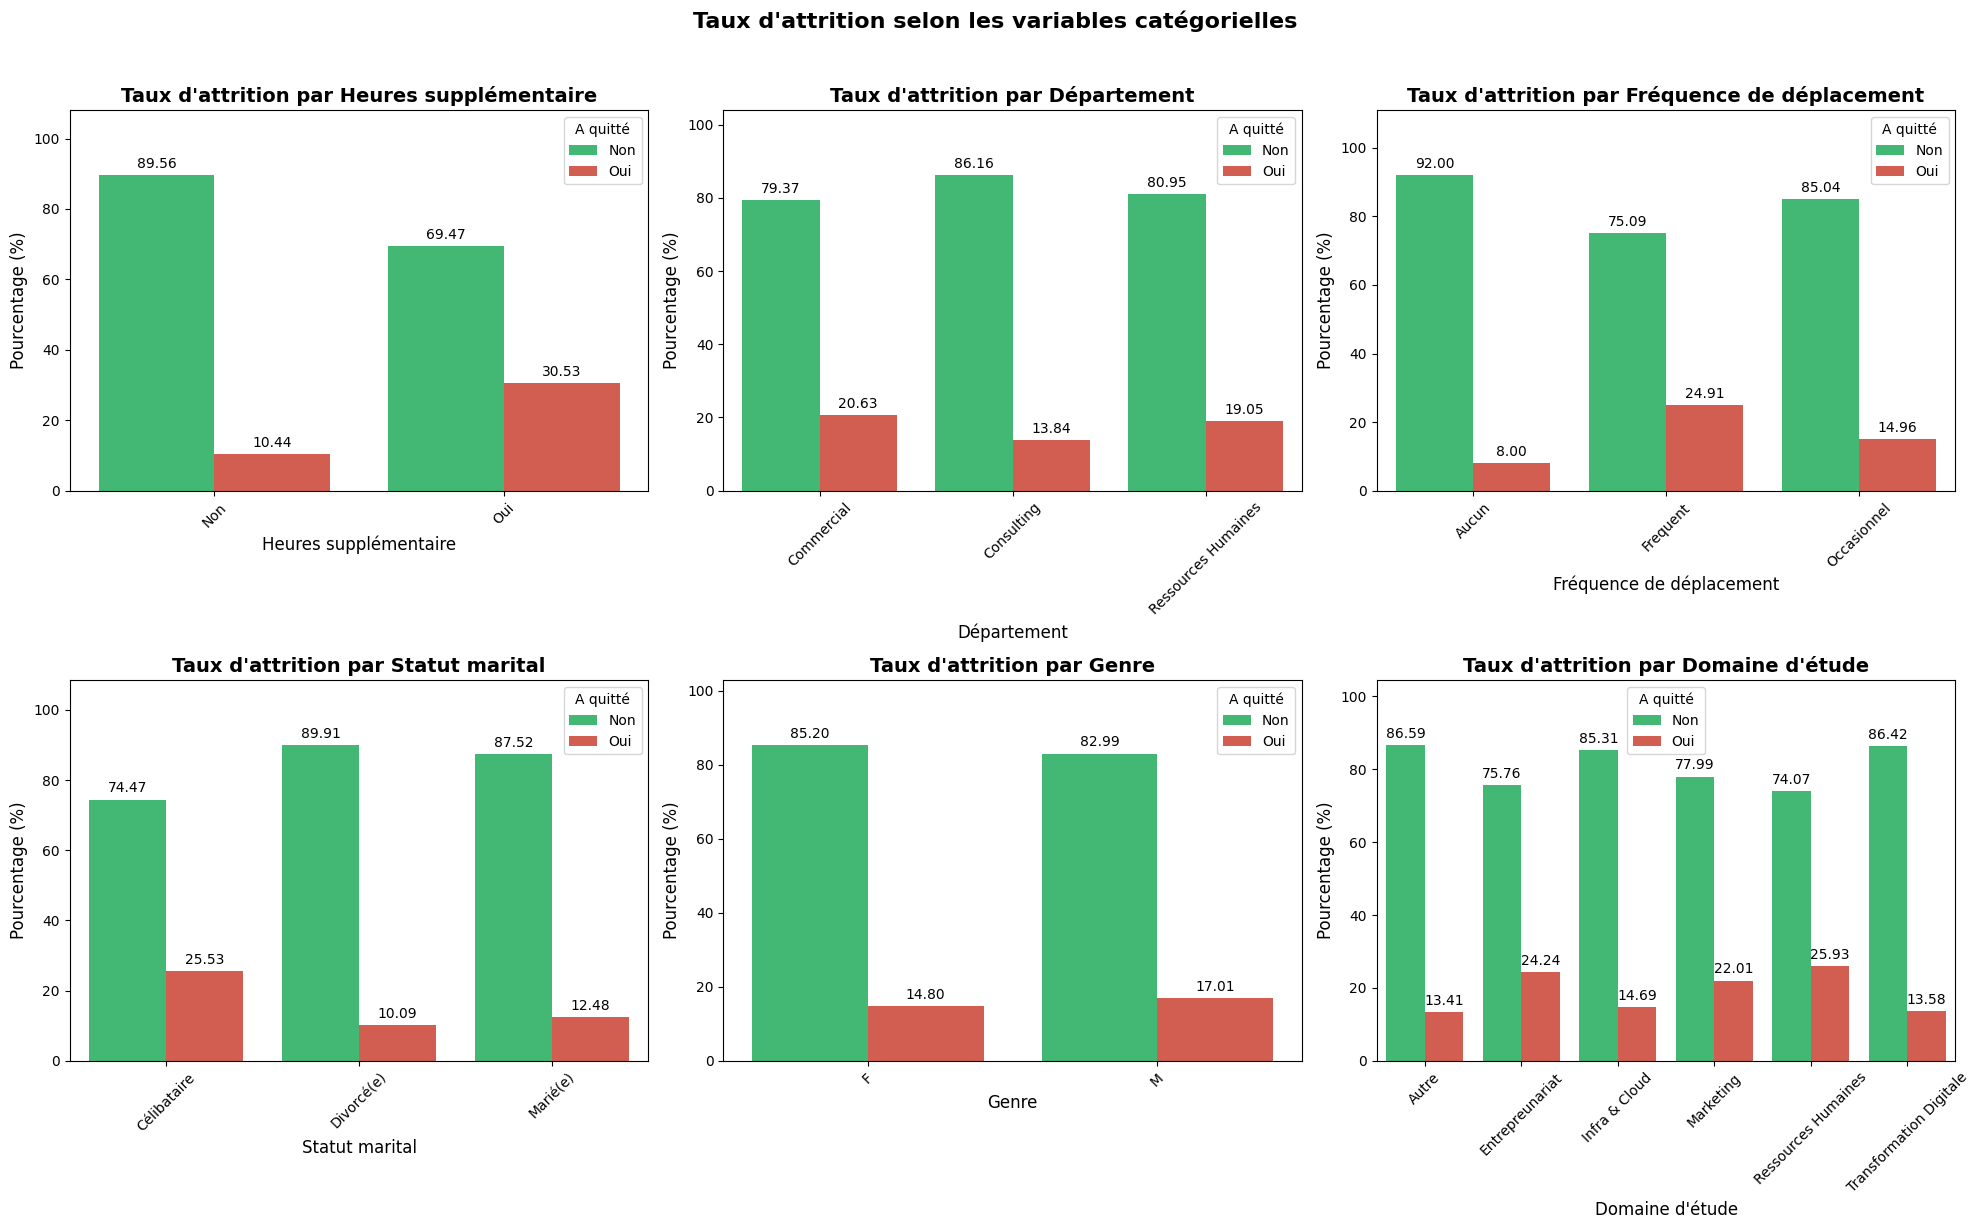

In [32]:
colonnes_quali = [
    ('heure_supplementaires', 'Heures supplémentaire'),
    ('departement', 'Département'),
    ('frequence_deplacement', 'Fréquence de déplacement'),
    ('statut_marital', 'Statut marital'),
    ('genre', 'Genre'),
    ('domaine_etude', 'Domaine d\'étude'),
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
for i, (col, label) in enumerate(colonnes_quali):
    # Préparer les données au format long
    df_temp = df.groupby([col, TARGET]).size().reset_index(name='count')
    df_temp['percentage'] = df_temp.groupby(col)['count'].transform(lambda x: x / x.sum() * 100)
    
    title = f"Taux d'attrition par {label}"
    vi.create_barplot(
        df=df_temp,
        x=col,
        y='percentage',
        hue=TARGET,
        ax=axes[i],
        palette=PALETTE_TARGET,
        title=title,
        xlabel=label,
        ylabel='Pourcentage (%)',
        legend ='A quitté'
        )
plt.suptitle("Taux d'attrition selon les variables catégorielles", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

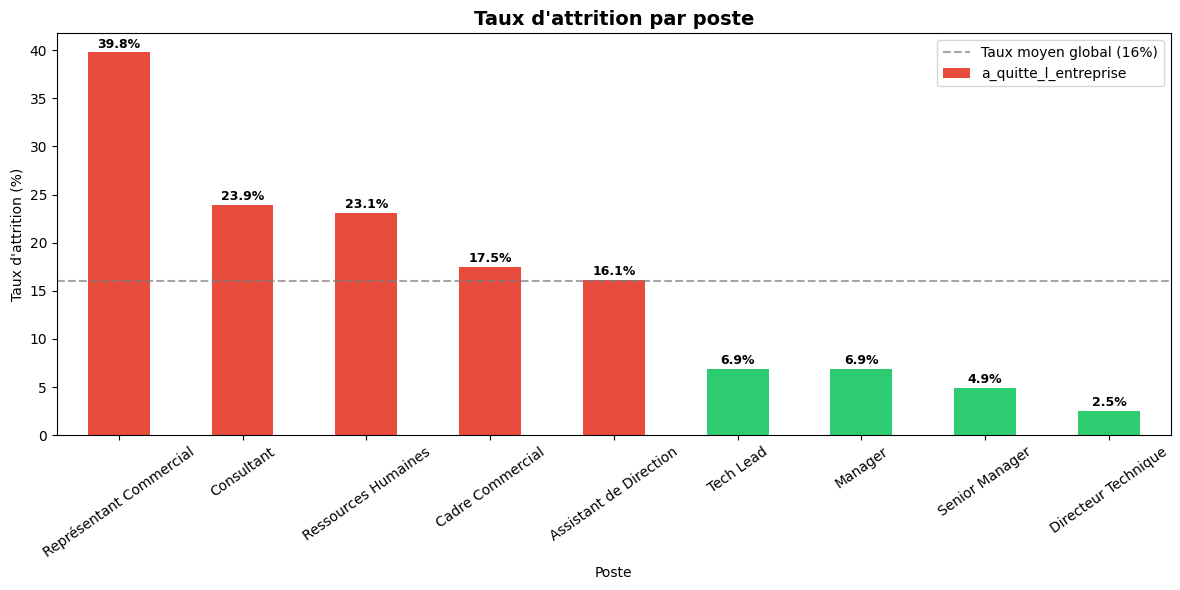

In [33]:
# Taux d'attrition par poste (variable à forte cardinalité, graphique dédié)
taux_attrition_poste = (
    df.groupby('poste')[TARGET]
    .apply(lambda x: (x == 'Oui').mean() * 100)
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(12, 6))
taux_attrition_poste.plot(kind='bar', ax=ax, color=['#e74c3c' if v > 16 else '#f39c12' if v > 10 else '#2ecc71' for v in taux_attrition_poste])
ax.axhline(y=16, color='gray', linestyle='--', alpha=0.7, label='Taux moyen global (16%)')
ax.set_title("Taux d'attrition par poste", fontsize=14, fontweight='bold')
ax.set_xlabel('Poste')
ax.set_ylabel("Taux d'attrition (%)")
ax.tick_params(axis='x', rotation=35)
ax.legend()

for i, v in enumerate(taux_attrition_poste):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

**Observations sur les variables catégorielles :**

- Les **heures supplémentaires** constituent le facteur le plus discriminant : les employés qui en effectuent présentent un taux d’attrition nettement plus élevé, suggérant une surcharge de travail ou un déséquilibre vie professionnelle / vie personnelle.

- Une **fréquence de déplacement élevée** est associée à une hausse de l’attrition, indiquant que la mobilité professionnelle peut être un facteur de fatigue ou de démotivation.

- Le **poste occupé** présente une forte hétérogénéité des taux d’attrition. Certains postes (Représentant Commercial, Consultant, Ressources Humaines) affichent des taux supérieurs à la **moyenne des taux d’attrition par poste**, tandis que les postes managériaux ou techniques avancés sont plus stables.

- Le **département** montre des écarts modérés d’attrition : les départements Ventes et Ressources Humaines sont légèrement plus exposés, tandis que les départements R&D et IT présentent des taux plus faibles, suggérant un effet indirect lié à la répartition des postes.

- Pris seul, le **genre** ne semble pas avoir d’impact. Mais pour en être sûr, il faudrait analyser le genre avec d’autres facteurs (poste, ancienneté…). Il peut jouer un rôle indirect selon les métiers, surtout dans une ESN où certains postes restent genrés. Il faut donc rester prudent avant de conclure qu’il n’a aucun effet.

- Le **domaine d’étude** affiche une hétérogénéité modérée des taux d’attrition. Certains domaines (Marketing, Ressources Humaines, Entrepreneuriat) sont plus touchés, probablement en lien avec le type de poste et les opportunités externes associées.

- Le **statut marital** met en évidence une légère surreprésentation des employés célibataires parmi les départs, bien que cet effet reste secondaire par rapport aux variables organisationnelles.

**Synthèse :**
L’attrition est principalement influencée par des **facteurs liés aux conditions de travail et à l’organisation** (charge de travail, déplacements, nature du poste), tandis que les variables démographiques apportent un signal complémentaire mais globalement moins discriminant. Ces résultats confirment l’intérêt d’une modélisation prédictive intégrant prioritairement les variables opérationnelles.


#### Analyse des variables ordinales (satisfaction et niveaux)

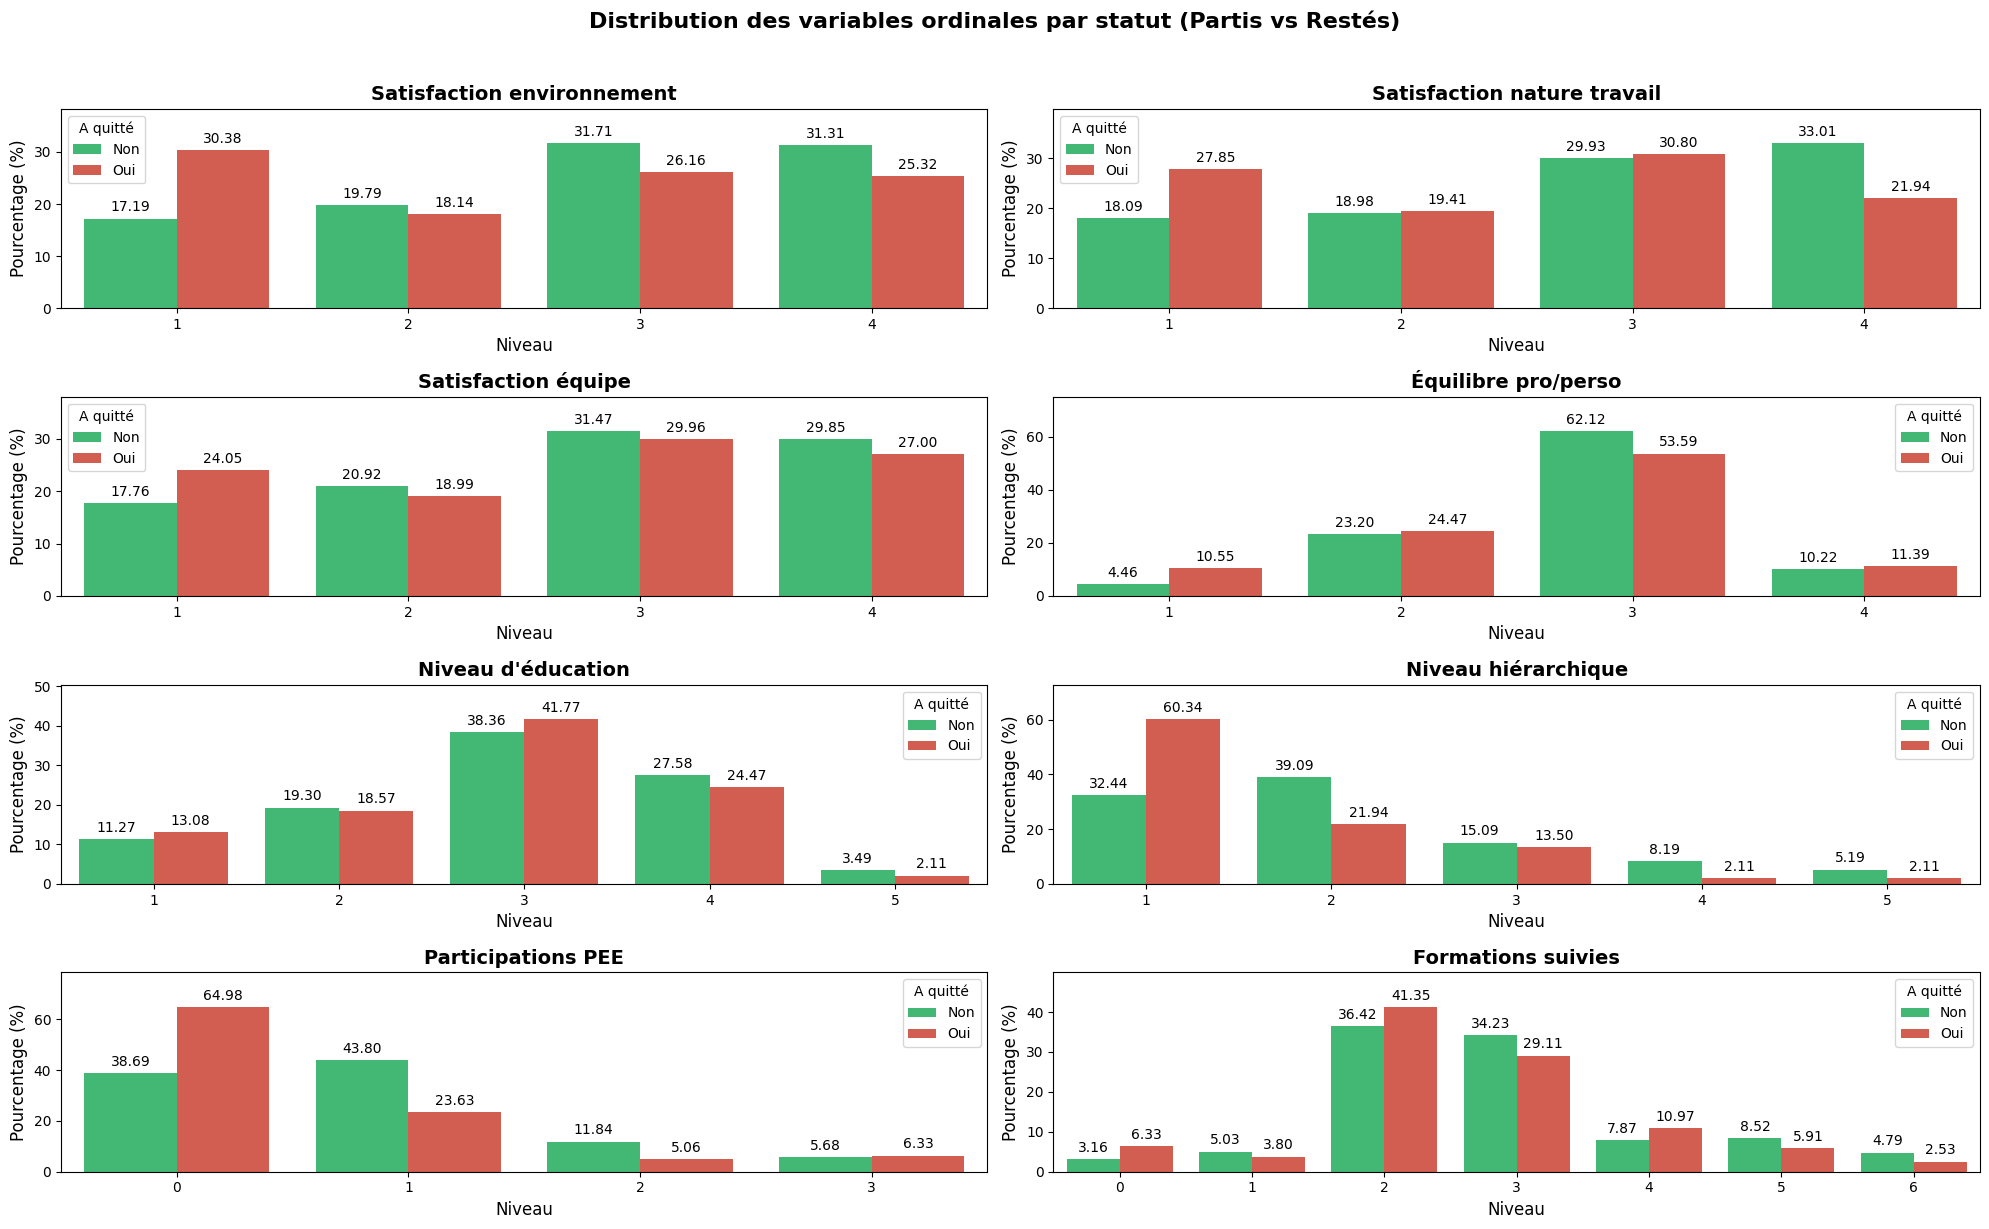

In [34]:
colonnes_ordinales = [
    ('satisfaction_employee_environnement', 'Satisfaction environnement'),
    ('satisfaction_employee_nature_travail', 'Satisfaction nature travail'),
    ('satisfaction_employee_equipe', 'Satisfaction équipe'),
    ('satisfaction_employee_equilibre_pro_perso', 'Équilibre pro/perso'),
    ('niveau_education', "Niveau d'éducation"),
    ('niveau_hierarchique_poste', 'Niveau hiérarchique'),
    ('nombre_participation_pee', 'Participations PEE'),
    ('nb_formations_suivies', 'Formations suivies'),
]

fig, axes = plt.subplots(4, 2, figsize=(20, 12))
axes = axes.flatten()

for i, (col, label) in enumerate(colonnes_ordinales):
    # Transformer le crosstab en format long pour seaborn
    ct = pd.crosstab(df[col], df[TARGET], normalize='columns') * 100
    ct_long = ct.reset_index().melt(
        id_vars=col, var_name=TARGET, value_name='pourcentage'
    )

    vi.create_barplot(
        ct_long,
        ax=axes[i],
        x=col,
        y='pourcentage',
        hue=TARGET,
        title=label,
        xlabel='Niveau',
        ylabel='Pourcentage (%)',
        legend='A quitté',
        xticks=0,
        palette=PALETTE_TARGET,
        annot=True,
    )

plt.suptitle(
    "Distribution des variables ordinales par statut (Partis vs Restés)",
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()


**Observations sur les variables ordinales (satisfaction et niveaux) :**

- Les employés présentant un **faible niveau de satisfaction environnementale** (niveau 1) sont nettement surreprésentés parmi les départs, tandis que les niveaux de satisfaction élevés (3 et 4) sont majoritairement associés aux employés restés. Cela suggère un lien clair entre les conditions de travail perçues et l’attrition.

- Une tendance similaire est observée pour la **satisfaction vis-à-vis de l’équipe** : les niveaux de satisfaction les plus bas sont plus fréquents chez les employés ayant quitté l’entreprise, soulignant l’importance du climat relationnel dans la rétention.

- La **satisfaction liée à la nature du travail** montre également un gradient clair : les faibles niveaux sont davantage représentés parmi les départs, tandis que les employés plus satisfaits tendent à rester plus souvent.

- L’**équilibre vie professionnelle / vie personnelle** ne présente pas de rupture très marquée entre les employés partis et restés. Les distributions sont proches, bien qu’un léger excès de faibles niveaux soit observable chez les employés ayant quitté l’entreprise, indiquant un effet plus modéré que pour les autres dimensions de satisfaction.

- Le **niveau hiérarchique** est fortement discriminant : les employés occupant les niveaux hiérarchiques les plus bas sont largement surreprésentés parmi les départs, tandis que les niveaux hiérarchiques plus élevés affichent une meilleure stabilité.

- Le **niveau d’éducation** montre des différences limitées entre les deux groupes. Les répartitions restent globalement similaires, suggérant un pouvoir explicatif faible de cette variable prise isolément.

- La **participation au PEE** (plan d’épargne entreprise) est associée à une plus faible attrition. Les employés ne participant pas au PEE sont nettement surreprésentés parmi les départs, ce qui suggère un lien entre engagement financier dans l’entreprise et rétention.

- Le **nombre de formations suivies** montre une tendance modérée : les employés ayant suivi peu ou pas de formations sont plus fréquemment parmi les départs, tandis que ceux ayant bénéficié de davantage de formations semblent légèrement plus stables.

**Synthèse :**
Les variables ordinales liées à la **satisfaction au travail** et à l’**engagement dans l’entreprise** (participation au PEE, accès à la formation) présentent un signal clair vis-à-vis de l’attrition. À l’inverse, le niveau d’éducation et l’équilibre pro/perso apparaissent moins discriminants pris isolément. Ces résultats montrent que la perception du travail et les leviers d’engagement jouent un rôle important dans les départs.



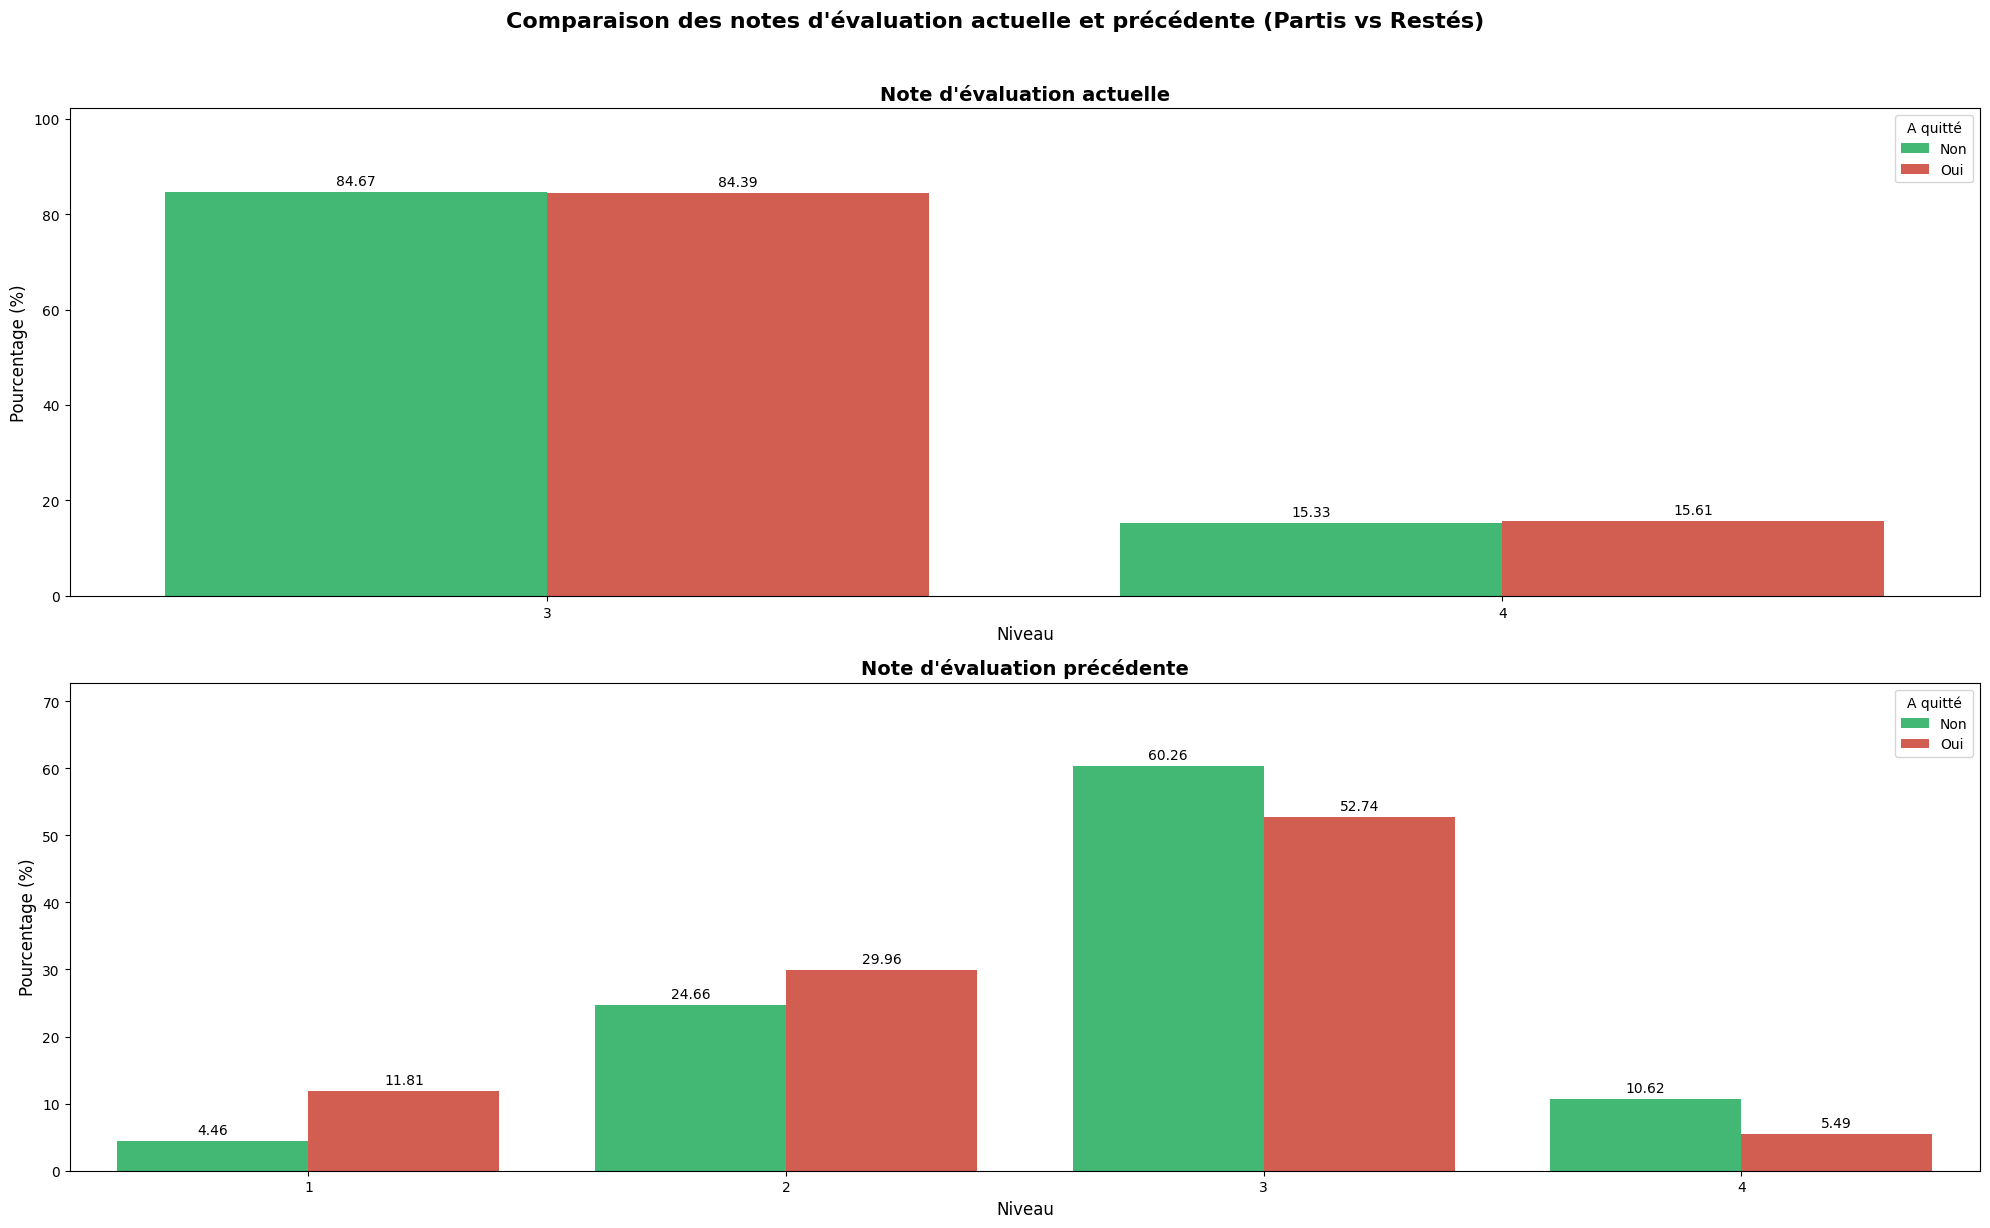

In [35]:
colonnes_ordinales = [
    ('note_evaluation_actuelle', 'Note d\'évaluation actuelle'),
    ('note_evaluation_precedente', 'Note d\'évaluation précédente'),
]

fig, axes = plt.subplots(2, 1, figsize=(20, 12))
# axes = axes.flatten()

for i, (col, label) in enumerate(colonnes_ordinales):
    # Transformer le crosstab en format long pour seaborn
    ct = pd.crosstab(df[col], df[TARGET], normalize='columns') * 100
    ct_long = ct.reset_index().melt(
        id_vars=col, var_name=TARGET, value_name='pourcentage'
    )

    vi.create_barplot(
        ct_long,
        ax=axes[i],
        x=col,
        y='pourcentage',
        hue=TARGET,
        title=label,
        xlabel='Niveau',
        ylabel='Pourcentage (%)',
        legend='A quitté',
        xticks=0,
        palette=PALETTE_TARGET,
        annot=True,
    )

plt.suptitle(
    "Comparaison des notes d'évaluation actuelle et précédente (Partis vs Restés)",
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()


**Observations sur les notes d’évaluation (actuelle et précédente) :**

- La **note d’évaluation actuelle** ne montre pas de différence notable entre les employés partis et restés. Les répartitions sont très proches, ce qui suggère que cette variable, prise seule, explique peu les départs.

- La **note d’évaluation précédente** met en revanche en évidence des différences plus marquées. Les employés ayant quitté l’entreprise sont plus souvent associés à des **niveaux d’évaluation faibles (1 et 2)**, tandis que les employés restés présentent plus fréquemment des **niveaux élevés (3 et 4)**.

- Cela indique que l’historique des évaluations apporte davantage d’information que la note la plus récente.

**Synthèse :**
La note d’évaluation actuelle est peu informative pour expliquer les départs, alors que la note d’évaluation précédente apporte un signal plus intéressant. Il peut donc être utile de prendre en compte l’évolution des évaluations pour mieux comprendre et anticiper les départs.


#### Analyse des relations entre variables quantitatives

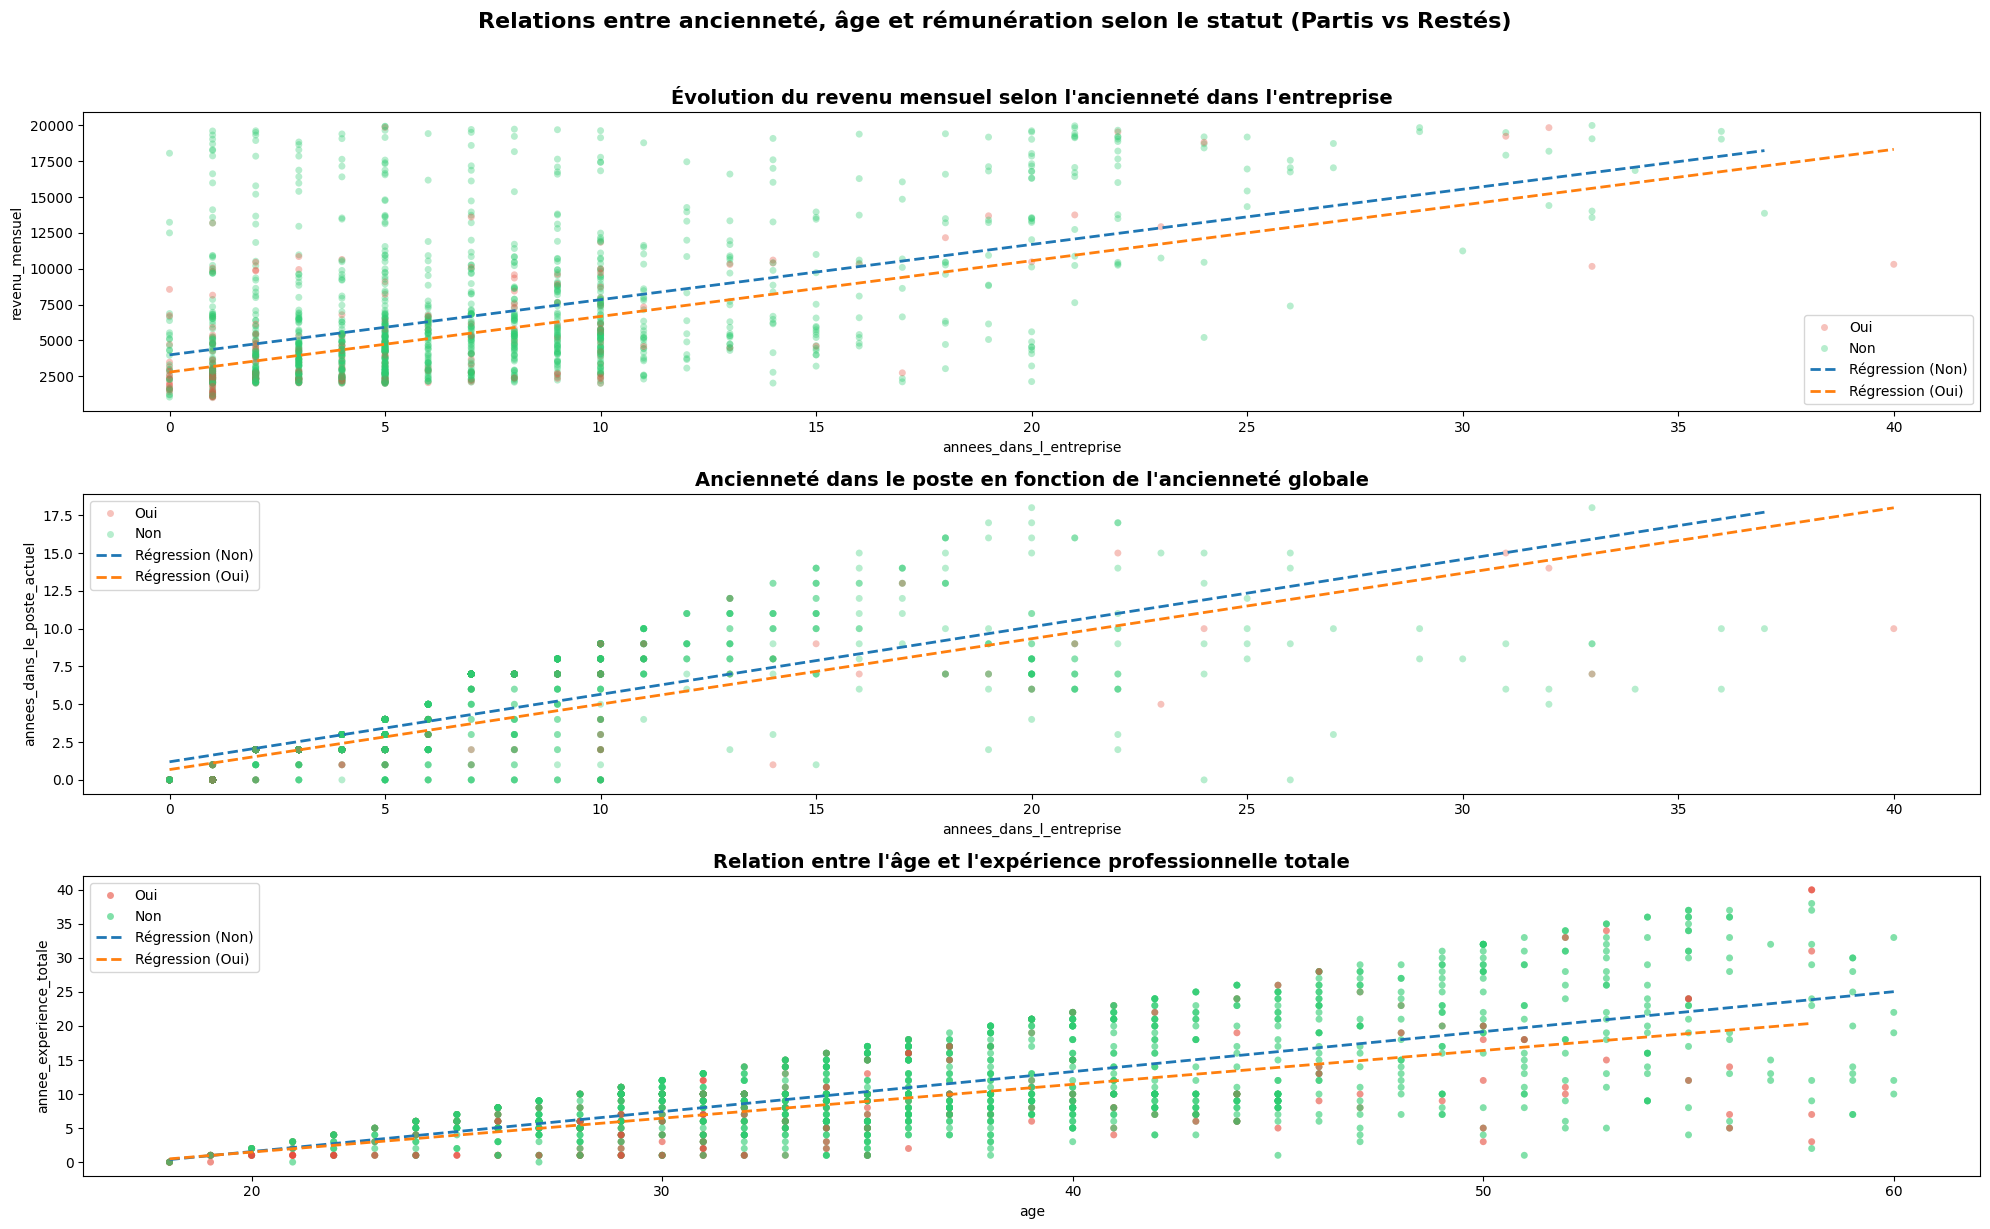

In [36]:
fig, axes = plt.subplots(3,1, figsize=(20, 12))
# axes = axes.flatten()
vi.create_scatterplot(
	df=df,
	x='annees_dans_l_entreprise',
	y='revenu_mensuel',
	hue=TARGET,
	palette=PALETTE_TARGET,
	ax=axes[0],
	regression=True,
	title="Évolution du revenu mensuel selon l'ancienneté dans l'entreprise",
)


vi.create_scatterplot(
	df=df,
	x='annees_dans_l_entreprise',
	y='annees_dans_le_poste_actuel',
	hue=TARGET,
	palette=PALETTE_TARGET,
	ax=axes[1],
	regression=True,
	title="Ancienneté dans le poste en fonction de l'ancienneté globale")

vi.create_scatterplot(df=df, x='age', y='annee_experience_totale',
                hue=TARGET, palette=PALETTE_TARGET, alpha=0.6, ax=axes[2],
	regression=True, title="Relation entre l'âge et l'expérience professionnelle totale")

plt.suptitle(
    "Relations entre ancienneté, âge et rémunération selon le statut (Partis vs Restés)",
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()


**Observations sur les variables numériques (ancienneté, âge et rémunération) :**

- Le **revenu mensuel** augmente globalement avec l’**ancienneté dans l’entreprise**, comme le montre la tendance linéaire. Cependant, les employés partis et restés sont répartis de manière similaire, indiquant que le niveau de revenu, pris isolément, n’explique pas clairement les départs.

- L’**ancienneté dans le poste** est positivement liée à l’ancienneté globale dans l’entreprise. Les employés ayant quitté l’entreprise se retrouvent davantage parmi les profils ayant une **ancienneté plus faible dans leur poste**, suggérant une instabilité plus forte en début de trajectoire.

- L’**âge** est fortement corrélé à l’**expérience totale**, ce qui est attendu. Les employés partis sont majoritairement concentrés sur des niveaux d’âge et d’expérience plus faibles, tandis que les profils plus expérimentés apparaissent plus stables.

**Synthèse :**
Les variables liées à l’ancienneté, à l’âge et à l’expérience montrent des tendances cohérentes, mais prises individuellement, elles expliquent modérément les départs. Elles semblent surtout indiquer que les employés plus jeunes et moins expérimentés sont globalement plus susceptibles de quitter l’entreprise.


#### Analyse des relations entre variables qualitatives 

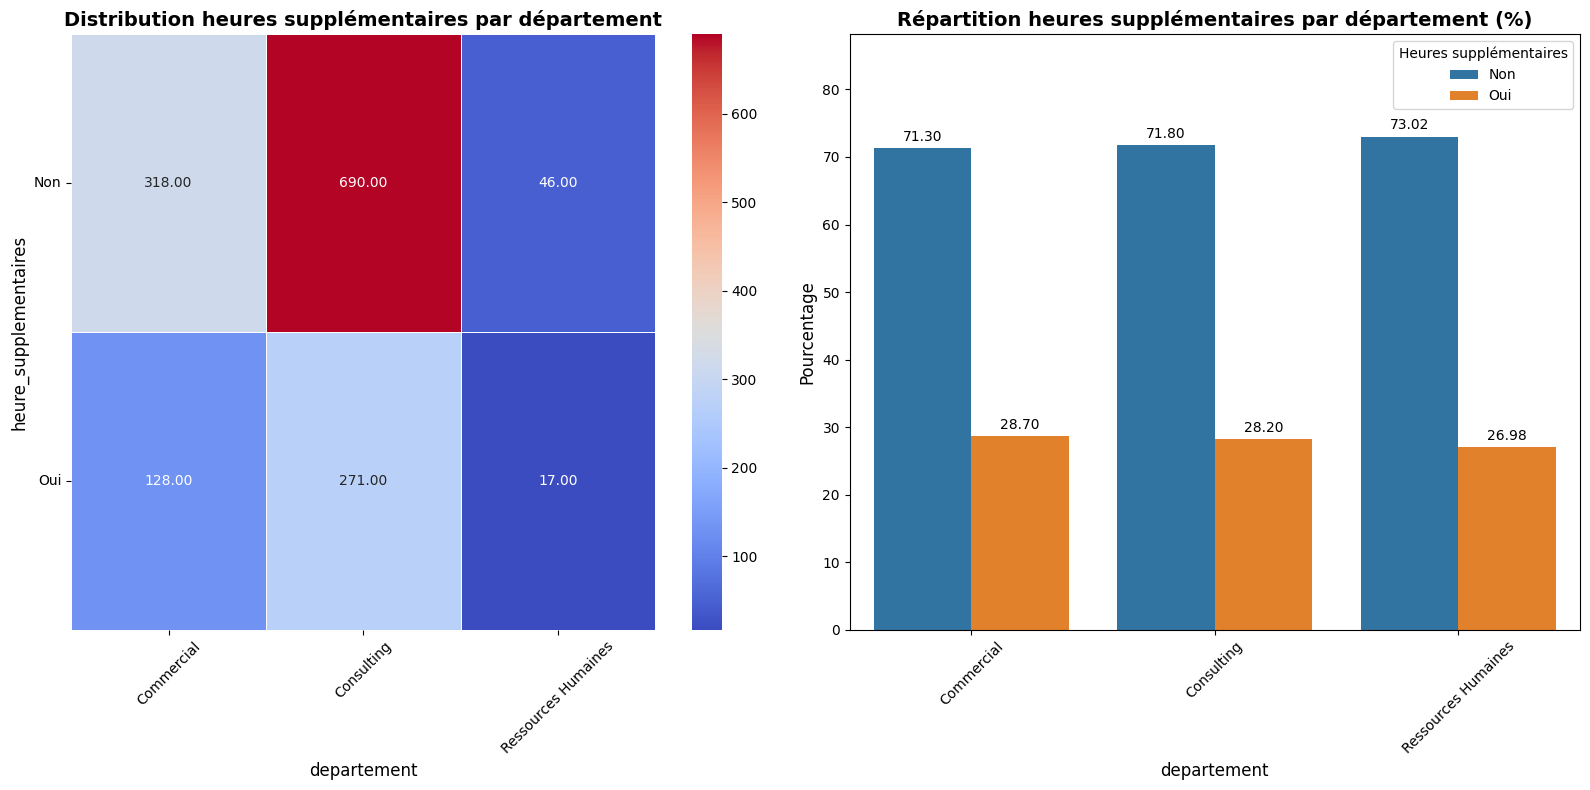

In [37]:
fig, axes = plt.subplots(1,2, figsize=(16, 8))
vi.plot_contingency_analysis(
	df, 
	rows='heure_supplementaires',
	cols='departement',
	axes=axes,
	heatmap_title="Distribution heures supplémentaires par département",
	barplot_title="Répartition heures supplémentaires par département (%)",
	legend_title="Heures supplémentaires",
)
plt.tight_layout()
plt.show()

**Observations sur les heures supplémentaires par département :**

- La répartition des **heures supplémentaires est globalement homogène entre les départements**. Environ 27 % à 29 % des employés effectuent des heures supplémentaires, quel que soit le département (Commercial, Consulting ou Ressources Humaines).

- Le **département Consulting** concentre le plus grand nombre absolu d’employés effectuant des heures supplémentaires, ce qui s’explique principalement par un **effectif total plus élevé**, et non par une proportion significativement différente.

- Les départements **Commercial** et **Ressources Humaines** présentent des proportions très proches d’heures supplémentaires, sans écart marqué susceptible d’expliquer à lui seul des différences d’attrition entre départements.

- Ces résultats suggèrent que les **heures supplémentaires constituent un facteur transversal**, dont l’impact sur l’attrition est **indépendant du département**, et davantage lié aux conditions individuelles de travail qu’à une organisation spécifique.

**Synthèse :**
Les heures supplémentaires sont réparties de manière relativement uniforme entre les départements. Leur rôle dans l’attrition semble donc lié à la **charge de travail individuelle** plutôt qu’à un effet structurel propre à un département donné.


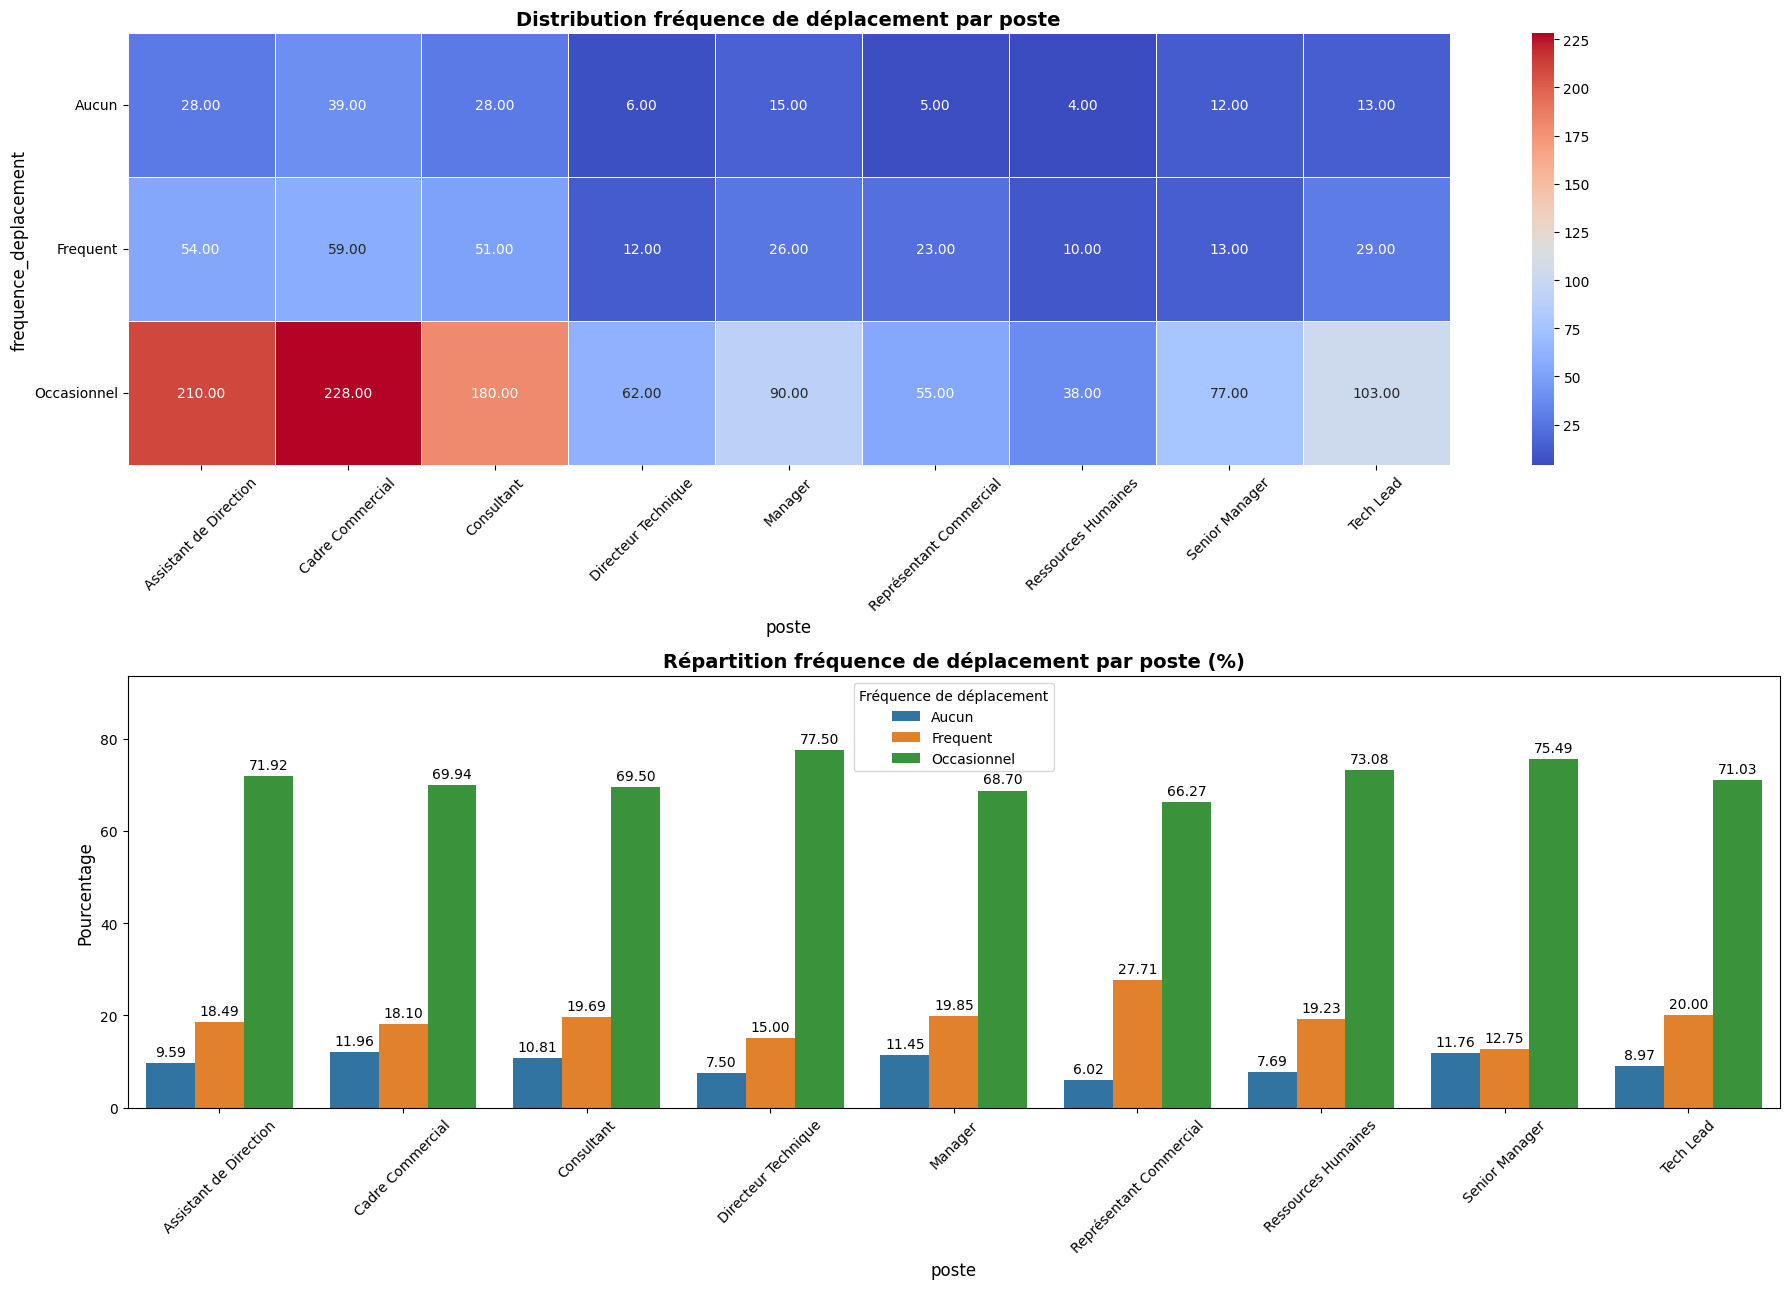

In [38]:
fig, axes = plt.subplots(2,1, figsize=(18, 13))
vi.plot_contingency_analysis(
	df, 
	rows='frequence_deplacement',
	cols='poste',
	axes=axes,
	heatmap_title="Distribution fréquence de déplacement par poste",
	barplot_title="Répartition fréquence de déplacement par poste (%)",
	legend_title="Fréquence de déplacement"
)
plt.tight_layout()
plt.show()

**Observations sur la fréquence de déplacement par poste :**

- La majorité des postes sont caractérisés par une **fréquence de déplacement occasionnelle**, représentant environ **65 % à 75 % des effectifs** selon le poste. Cela indique que les déplacements font partie intégrante de nombreux rôles, sans être systématiquement fréquents.

- Les postes à dominante **commerciale** (Représentant Commercial, Consultant, Cadre Commercial) présentent une **proportion plus élevée de déplacements fréquents**, traduisant une plus forte exigence de mobilité liée à la nature du poste.

- À l’inverse, les postes à responsabilité **technique ou managériale élevée** (Directeur Technique, Senior Manager, Tech Lead) affichent une part plus importante de déplacements occasionnels et une proportion plus faible de déplacements fréquents, suggérant des fonctions plus sédentaires ou stratégiques.

- Les postes avec **peu ou pas de déplacements** restent minoritaires dans l’ensemble des fonctions, quel que soit le poste occupé.

**Synthèse :**
La fréquence de déplacement est fortement liée au **type de poste**. Les rôles orientés vers le terrain ou la relation client impliquent davantage de mobilité, ce qui peut contribuer indirectement à l’attrition observée sur ces postes, tandis que les fonctions techniques et managériales semblent offrir une plus grande stabilité géographique.


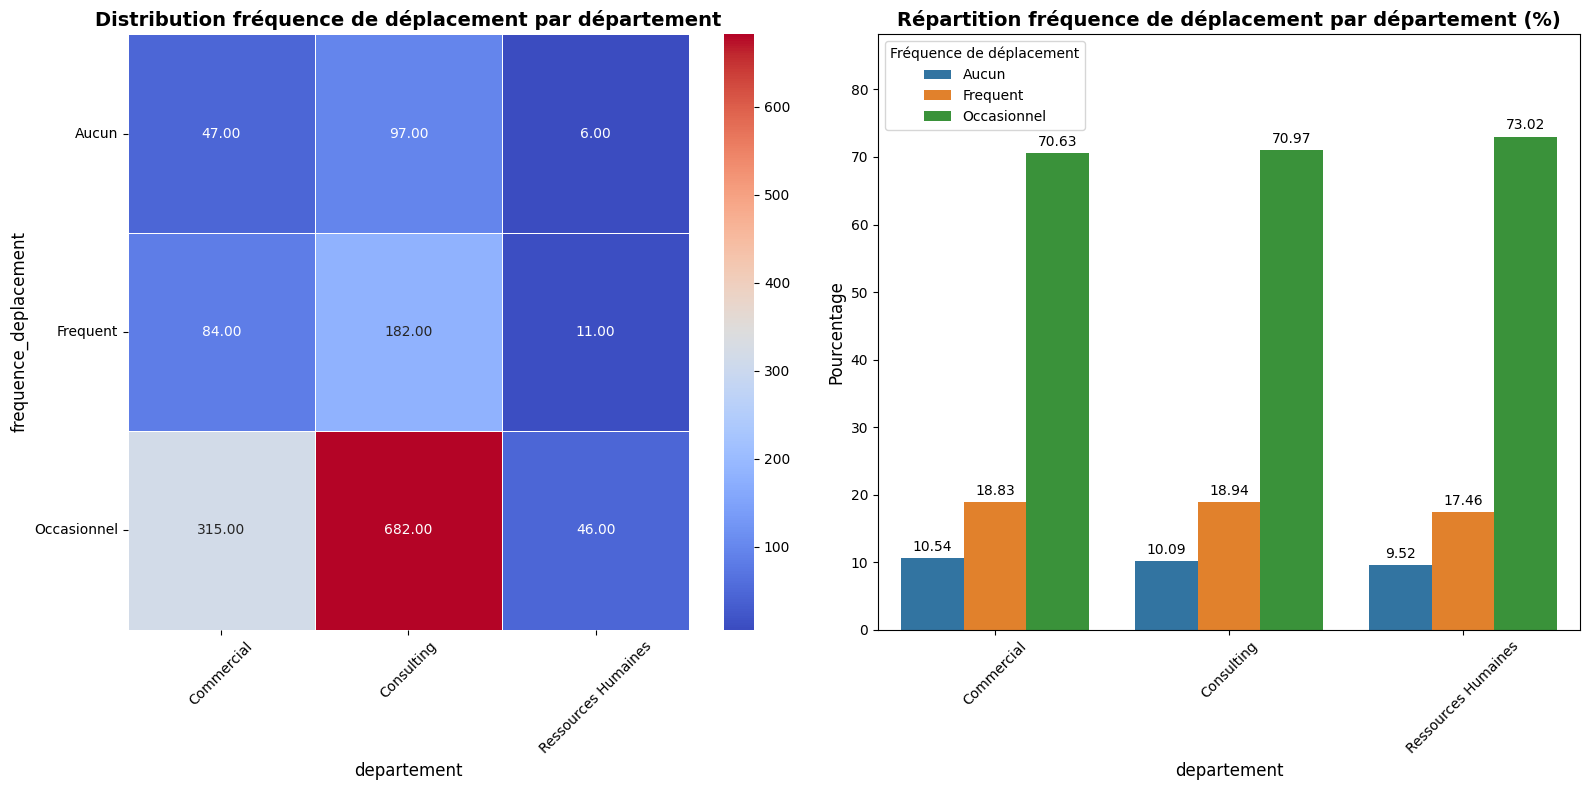

In [39]:
fig, axes = plt.subplots(1,2, figsize=(16, 8))
vi.plot_contingency_analysis(
	df, 
	rows='frequence_deplacement',
	cols='departement',
	axes=axes,
	heatmap_title="Distribution fréquence de déplacement par département",
	barplot_title="Répartition fréquence de déplacement par département (%)",
	legend_title="Fréquence de déplacement"
)
plt.tight_layout()
plt.show()

**Observations sur la fréquence de déplacement par département :**

- La **fréquence de déplacement occasionnelle** est largement majoritaire dans l’ensemble des départements, représentant environ **70 % à 73 % des effectifs**. Cela indique que les déplacements font partie du quotidien professionnel, sans être systématiquement intensifs.

- Les **déplacements fréquents** concernent une proportion comparable d’employés dans les départements **Commercial** et **Consulting** (environ 19 %), tandis qu’ils sont légèrement moins présents en **Ressources Humaines** (17,5 %).

- Les employés ne réalisant **aucun déplacement** restent minoritaires dans tous les départements (environ 9 % à 11 %), suggérant que la majorité des fonctions implique au moins un certain niveau de mobilité.

- Les écarts observés entre départements restent **relativement limités**, indiquant que la fréquence de déplacement est davantage liée à la **nature des postes** qu’à l’appartenance à un département spécifique.

**Synthèse :**
La fréquence de déplacement est globalement homogène entre les départements, avec une prédominance nette des déplacements occasionnels. Son impact potentiel sur l’attrition semble donc davantage dépendre des **caractéristiques individuelles des postes** que d’un effet structurel propre à un département.


### Synthèse de l’analyse exploratoire

L’analyse exploratoire met en évidence que l’attrition concerne principalement des employés **plus jeunes, moins expérimentés et moins ancrés dans l’entreprise**. Les départs surviennent majoritairement en début de parcours professionnel, avec des niveaux d’ancienneté et de rémunération plus faibles.

Les **conditions de travail** jouent un rôle central dans le turnover. Les heures supplémentaires, la fréquence des déplacements et la **nature du poste occupé** sont fortement associées aux départs. Ces facteurs apparaissent comme **transversaux**, avec des effets similaires entre départements, mais des différences marquées selon les postes. Certains postes opérationnels, notamment commerciaux et RH, présentent ainsi des taux d’attrition plus élevés, tandis que les postes techniques ou managériaux sont plus stables.

Les variables de **satisfaction au travail** constituent les signaux les plus discriminants. De faibles niveaux de satisfaction (environnement, équipe, contenu du travail), un **niveau hiérarchique bas**, ainsi qu’une **faible participation aux dispositifs d’engagement** (PEE, formations) sont fortement associés aux départs.

À l’inverse, les variables démographiques (genre, niveau d’éducation) et les facteurs ponctuels (dernière augmentation salariale) expliquent peu l’attrition pris isolément.

**En conclusion**, le turnover apparaît comme un phénomène multifactoriel dominé par la **stabilité professionnelle**, la **satisfaction au travail** et l’**organisation du travail**, ce qui justifie une approche de modélisation centrée sur ces dimensions.


## Préparer les données pour la modélisation

### Encodage des variables qualitatives

Dans le cadre de la préparation des données pour la modélisation, les variables qualitatives ont été encodées afin d’être compatibles avec les algorithmes de machine learning de `scikit-learn`.  
Les méthodes d’encodage ont été choisies en fonction du **sens métier des variables**.

#### Variables binaires
Les variables binaires sont encodées par un mapping explicite :
- **Genre** : F = 0, M = 1  
- **Heures supplémentaires** : Non = 0, Oui = 1  

#### Variable ordinale
La variable **frequence_deplacement** présente un ordre naturel entre ses modalités. Un encodage ordinal est donc utilisé :
- Aucun = 0  
- Occasionnel = 1  
- Fréquent = 2  

Cet encodage permet de conserver l’information liée à l’intensité des déplacements.

#### Variables nominales
Les variables nominales, sans ordre intrinsèque, sont encodées à l’aide d’un **OneHotEncoder** dans le pipeline de modélisation :
- Statut_marital  
- Departement  
- Poste  
- Domaine_etude  

Ce choix évite toute hiérarchie artificielle entre les catégories.

#### Variable cible
La variable cible **a_quitte_l_entreprise**, étant binaire, est encodée par un mapping
explicite (Non = 0, Oui = 1) lors de la séparation X/y.

In [40]:
df = pp.encode_categorical_features(df)
missing_value = du.analyze_missing_values(df)


🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%


### Feature Engineering

Création de nouvelles features à partir des variables existantes, dans l'objectif de capturer
des signaux métier plus fins que les variables brutes.

| Feature créée | Formule | Justification métier |
|---|---|---|
| `mobilite_interne` | `annees_dans_l_entreprise` - `annees_dans_le_poste_actuel` | Mesure l'évolution interne : une valeur faible peut indiquer une stagnation |
| `age_debut_carriere` | `age` - `annee_experience_totale` | Distingue les profils ayant commencé tôt (alternance) de ceux entrés tard (reconversion) |
| `stabilite_management` | `annees_sous_responsable_actuel` / (`annees_dans_le_poste_actuel` + 1) | Ratio de stabilité sous le même responsable, indicateur de turnover managérial |
| `score_satisfaction_global` | Moyenne des 4 variables de satisfaction | Synthèse de la satisfaction, réduit la dimensionnalité |
| `engagement_formation` | `nb_formations_suivies` / (`annees_dans_l_entreprise` + 1) | Intensité de formation rapportée à l'ancienneté |


In [41]:
df = pp.features_engineering(df)

### Analyse des features redondantes

#### Matrice de corrélation de Pearson



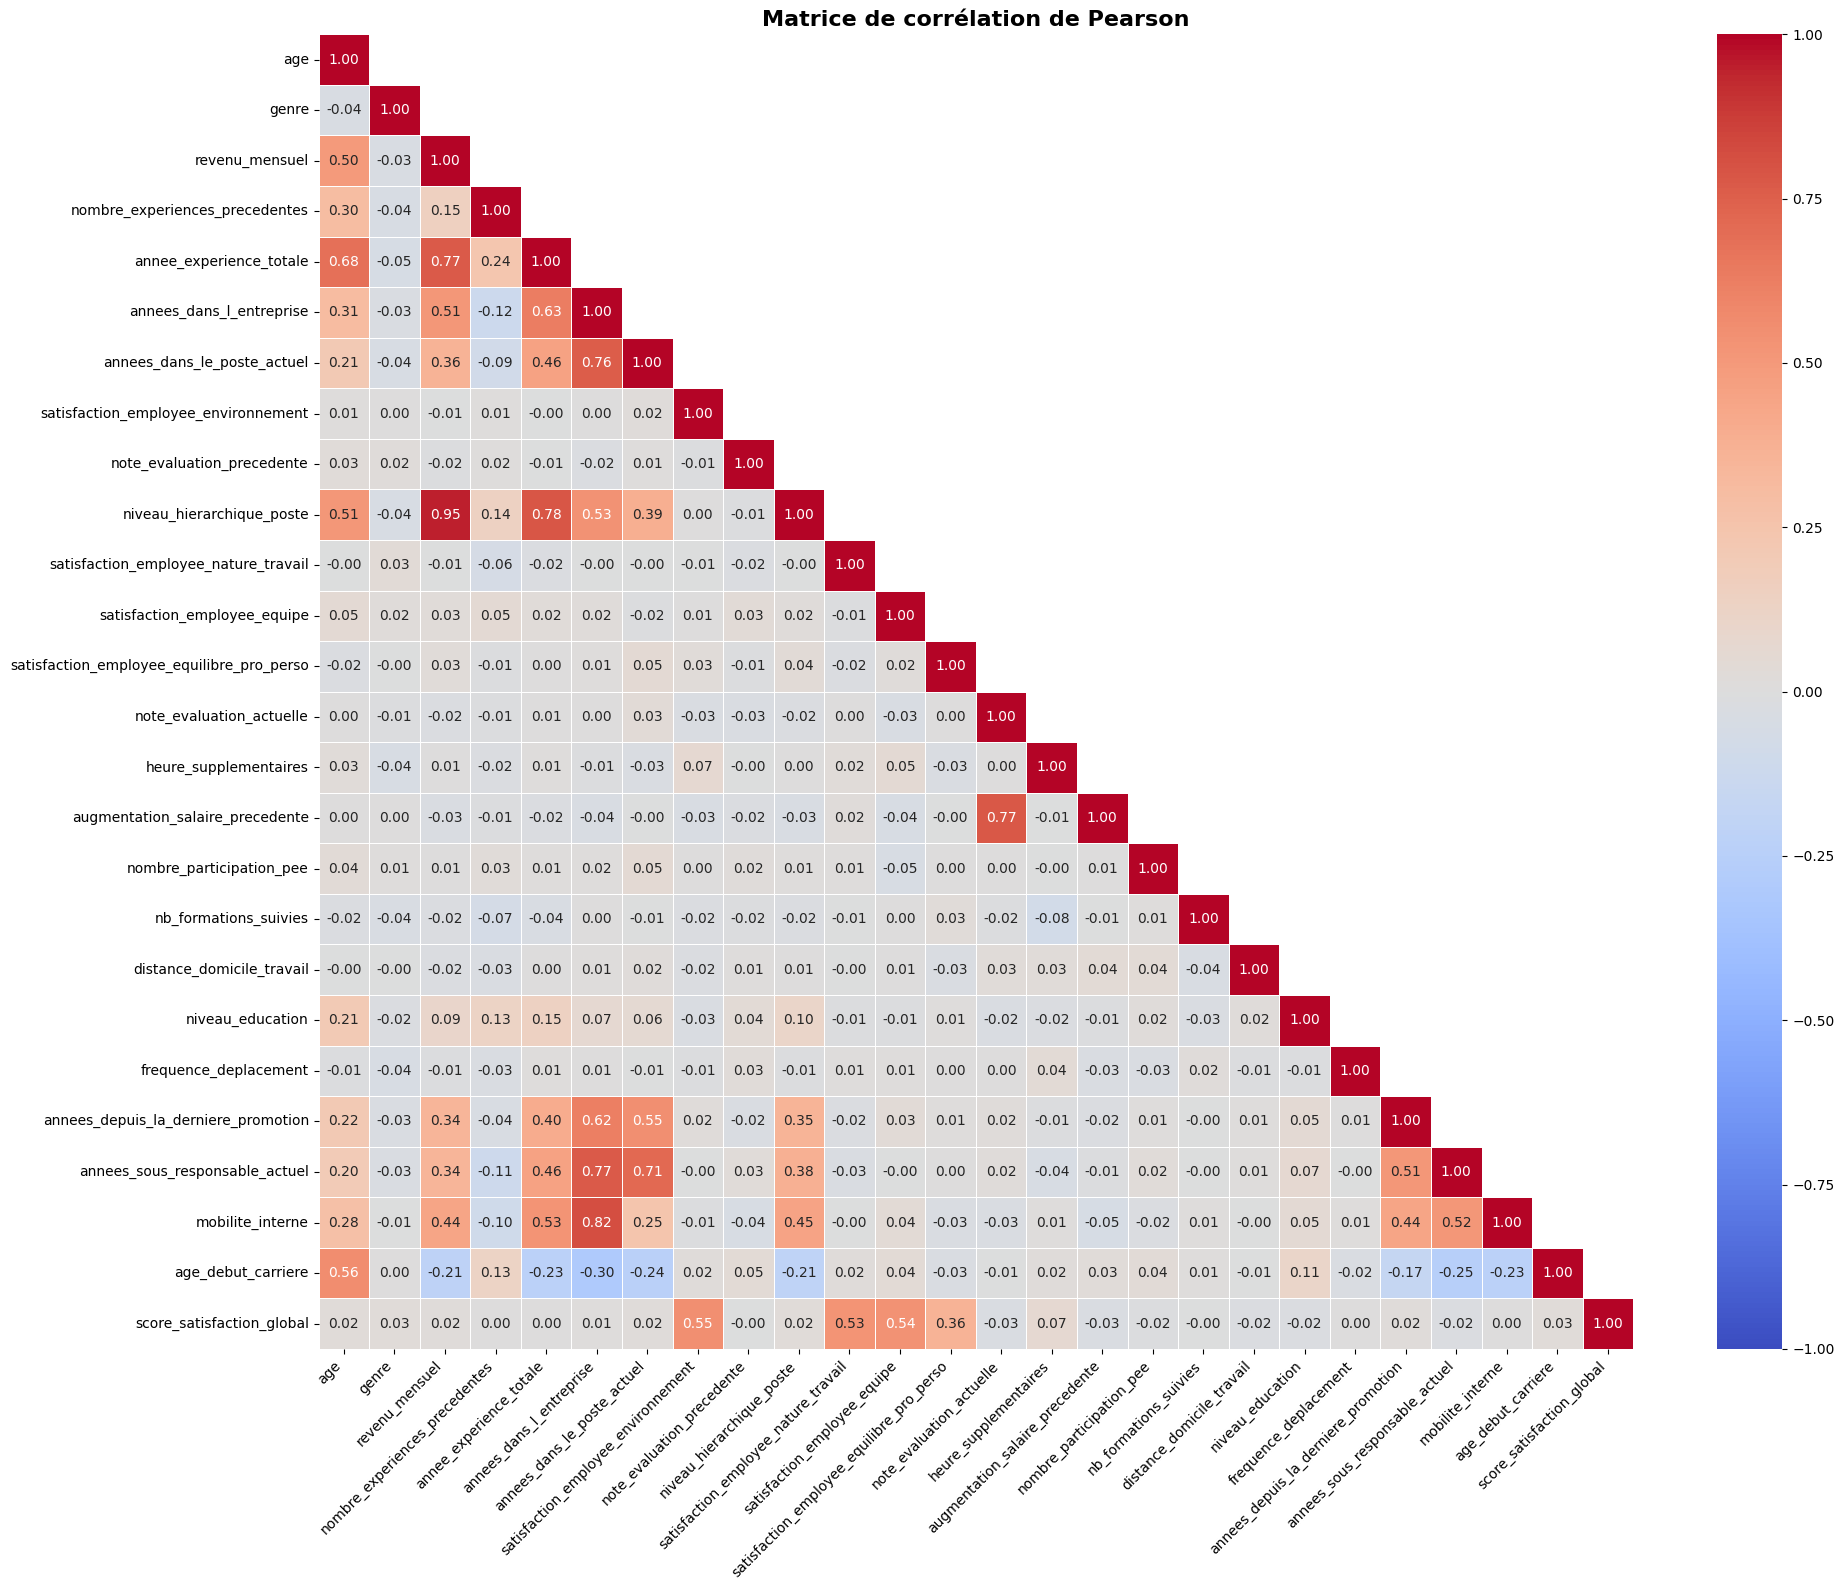

In [42]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

fig, axes = plt.subplots(1,1, figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

vi.create_heatmap(
	corr_matrix,
	axes,
	annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=0.5,
    mask=mask,
    vmin=-1, vmax=1
)

plt.title('Matrice de corrélation de Pearson', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Interprétation de la matrice de Pearson

**Corrélations très fortes (|r| > 0.75) — redondances identifiées :**

| Paire | Pearson | Interprétation |
|---|---|---|
| `revenu_mensuel` × `niveau_hierarchique_poste` | 0.95 | Quasi-déterministe : le grade fixe la grille salariale. **Redondance majeure**  bien que les deux portent un sens métier distinct (rémunération vs statut), on supprimera `niveau_hierarchique_poste` |
| `annees_dans_l_entreprise` × `mobilite_interne` | 0.82 | Attendu : `mobilite_interne` est dérivée de `annees_dans_l_entreprise` - `annees_dans_le_poste_actuel` |
| `annee_experience_totale` × `niveau_hierarchique_poste` | 0.78 | L'expérience conditionne le niveau hiérarchique |
| `revenu_mensuel` × `annee_experience_totale` | 0.77 | L'expérience tire le salaire vers le haut |
| `note_evaluation_actuelle` × `augmentation_salaire_precedente` | 0.77 | Lien RH direct : les augmentations suivent les évaluations |
| `annees_dans_l_entreprise` × `annees_sous_responsable_actuel` | 0.77 | Les employés restent longtemps sous le même responsable |
| `annees_dans_l_entreprise` × `annees_dans_le_poste_actuel` | 0.76 | Peu de mobilité interne en moyenne |

**Corrélations modérées (0.5 < |r| < 0.75) :**

| Paire | Pearson | Interprétation |
|---|---|---|
| `age` × `annee_experience_totale` | 0.68 | Corrélation naturelle, pas parfaite car l'âge de début de carrière varie |
| `annees_dans_l_entreprise` × `annees_depuis_la_derniere_promotion` | 0.62 | Les promotions s'espacent avec l'ancienneté |
| `age` × `age_debut_carriere` | 0.56 | Corrélation mécanique (l'une est dérivée de l'autre) |
| `satisfaction_*` × `score_satisfaction_global` | ~0.53 | Attendu : le score global est la moyenne des satisfactions individuelles |
| `annees_dans_l_entreprise` × `engagement_formation` | -0.50 | Les anciens suivent proportionnellement moins de formations |

#### Pairplot — corrélations non-linéaires

Visualisation des relations bivariées entre les principales features numériques, colorées par la variable cible.  
L'objectif est de détecter des **corrélations non-linéaires** que Pearson ne capte pas.

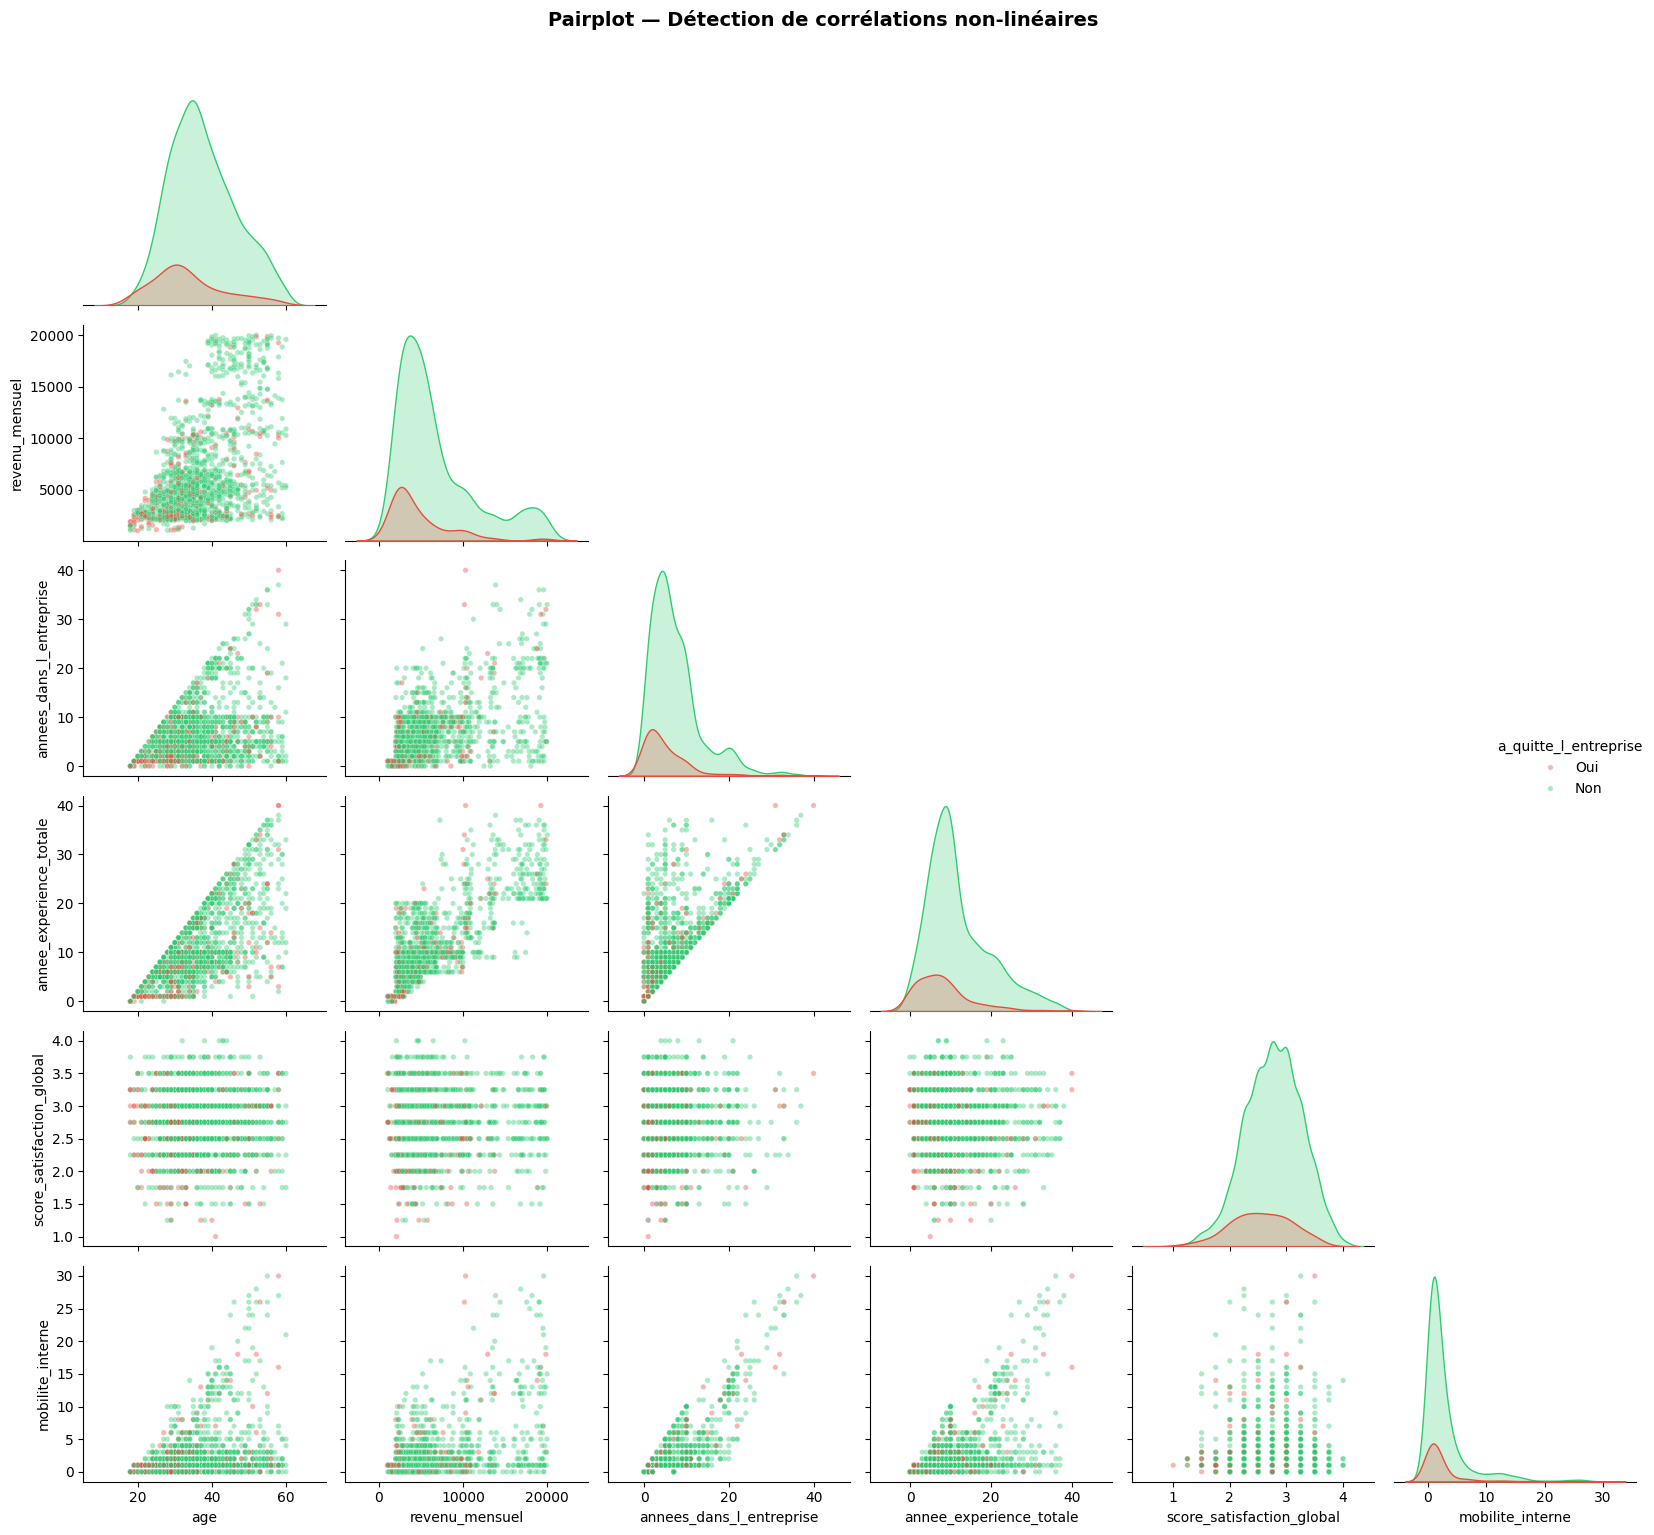

In [43]:
pairplot_cols = [
    'age',
    'revenu_mensuel',
    'annees_dans_l_entreprise',
    'annee_experience_totale',
    'score_satisfaction_global',
    'mobilite_interne',
    TARGET,
]

vi.create_pairplot(
    df,
    columns=pairplot_cols,
    hue=TARGET,
    palette=PALETTE_TARGET,
    title='Pairplot — Détection de corrélations non-linéaires',
)
plt.tight_layout()
plt.show()


#### Interprétation du pairplot

Le pairplot met en évidence plusieurs observations :

- **Age / Expérience totale** : relation linéaire positive attendue. Les employés ayant quitté
  l'entreprise (en rouge) se concentrent dans les tranches d'âge et d'expérience plus faibles.
- **Revenu mensuel / Ancienneté** : tendance croissante, avec les départs répartis de manière
  homogène. Le revenu seul ne discrimine pas clairement les deux populations.
- **Score de satisfaction global** : les distributions KDE (diagonale) montrent un léger
  décalage vers les valeurs basses pour les employés partis, cohérent avec l'analyse bivariée
  de l'étape 1.
- **Mobilité interne** : les employés partis sont davantage concentrés sur les valeurs faibles,
  suggérant un manque d'évolution interne.

Aucune relation non-linéaire complexe (forme en U, clusters séparés) n'est détectée
visuellement. Les corrélations entre les features sélectionnées sont essentiellement linéaires.


#### Matrice de corrélation de Spearman

Complément à la matrice de Pearson : Spearman mesure les **corrélations monotones** (linéaires ou non).  
Une forte corrélation de Spearman avec une faible corrélation de Pearson signale une relation non-linéaire.


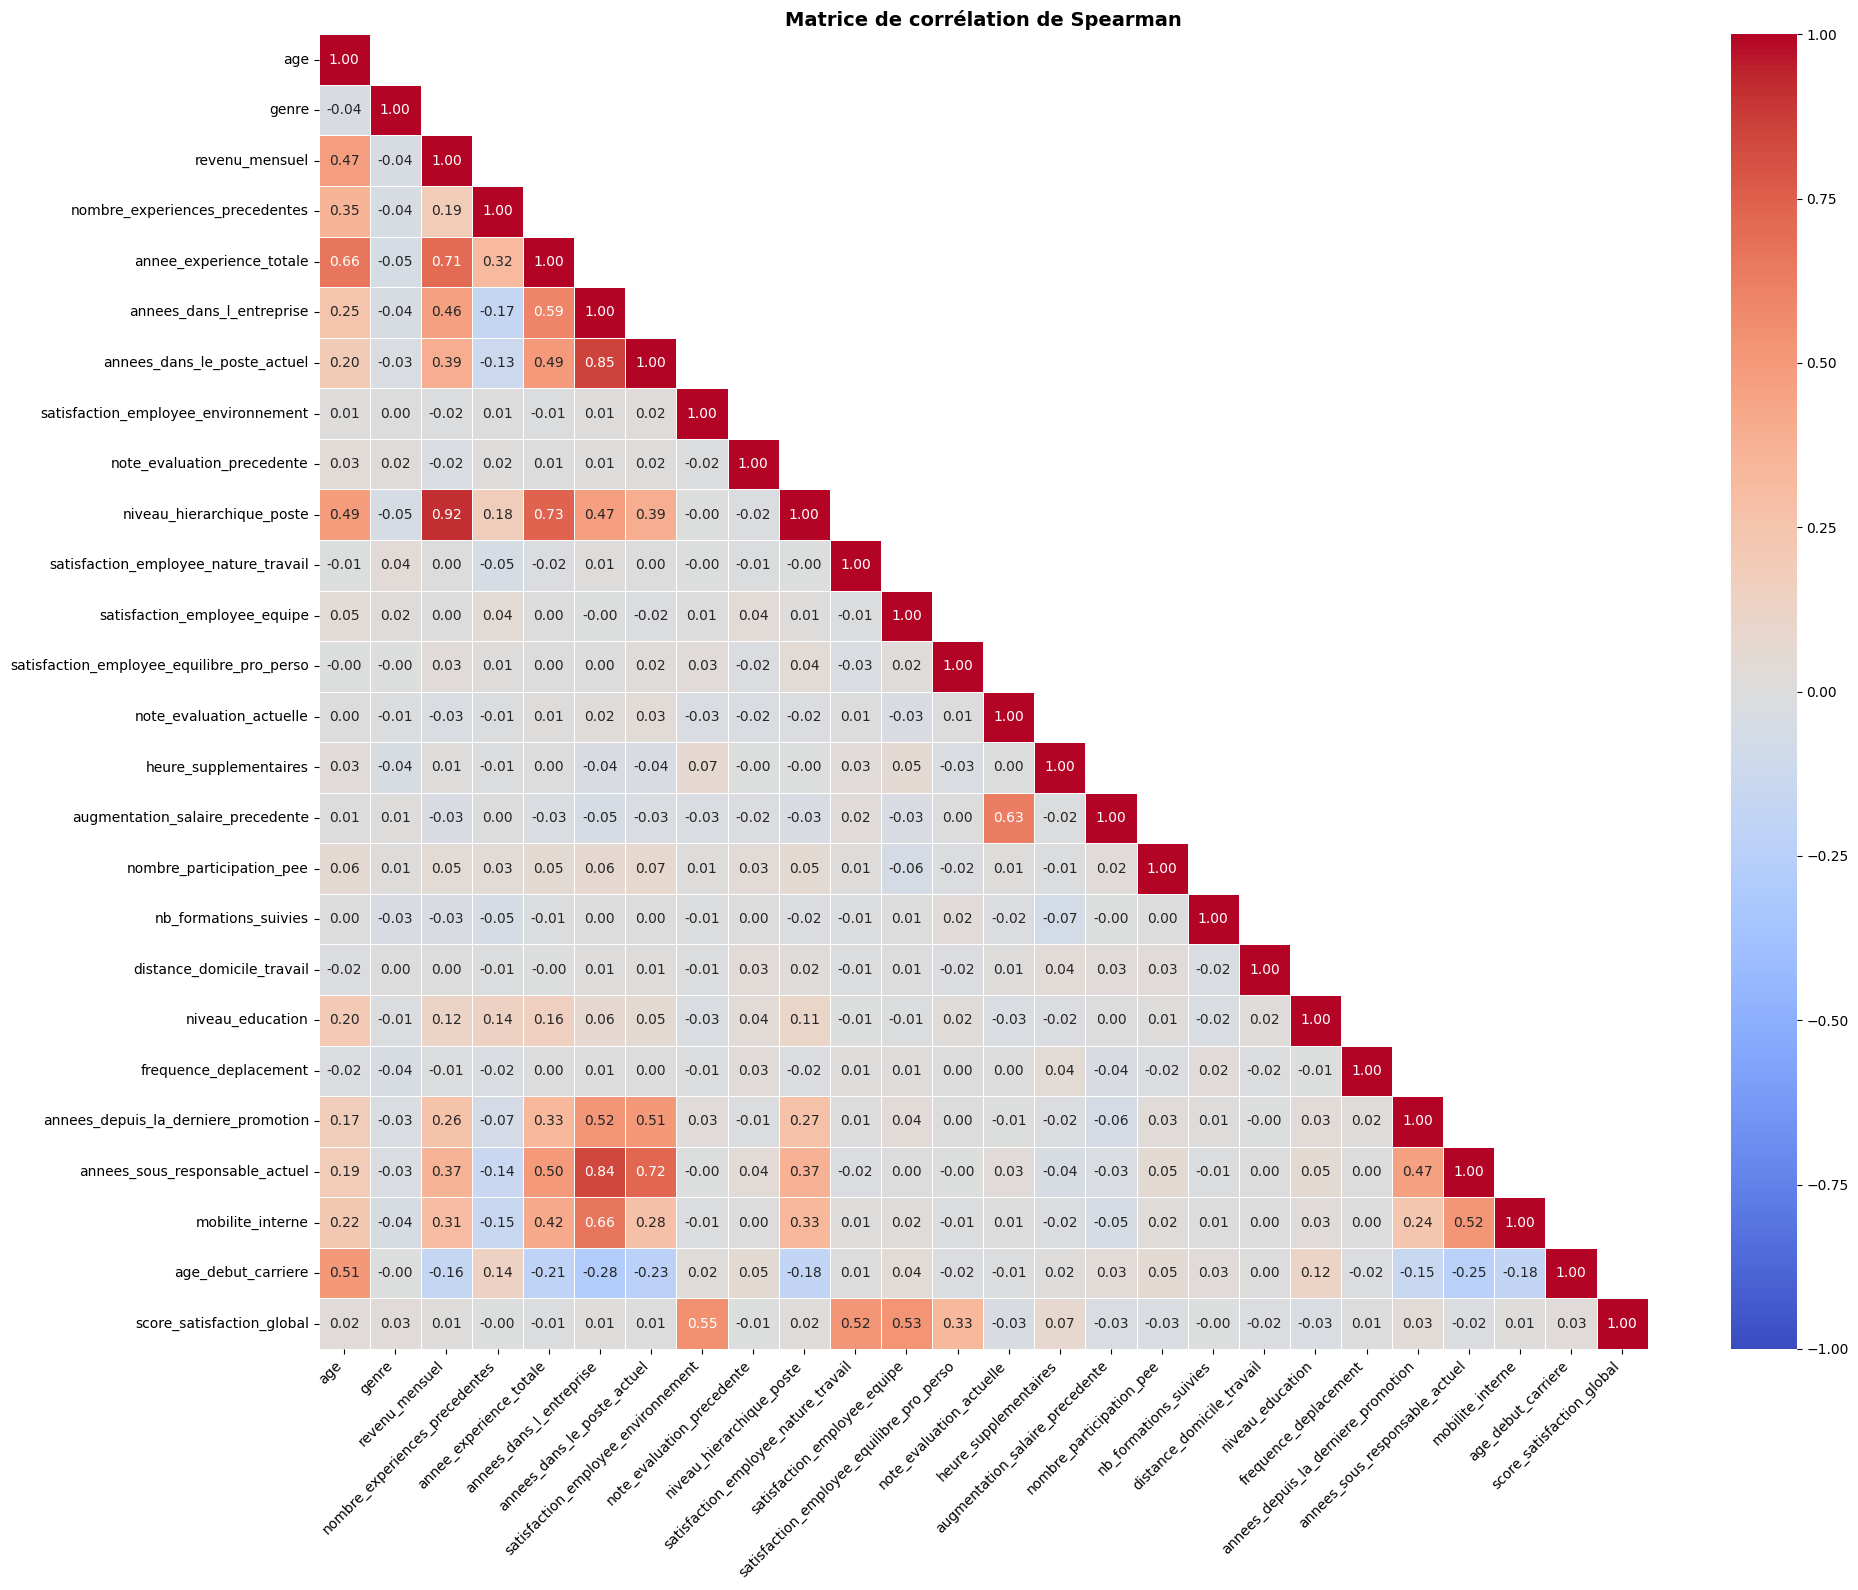

In [44]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
spearman_matrix = df[numeric_cols].corr(method='spearman')

fig, axes = plt.subplots(1, 1, figsize=(20, 16))
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool), k=1)

vi.create_heatmap(
    spearman_matrix,
	axes,
	title='Matrice de corrélation de Spearman',
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    mask=mask,
    vmin=-1, vmax=1,
	
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Interprétation de la matrice de Spearman

**Cohérence globale avec Pearson :**  
La majorité des corrélations sont comparables entre Pearson et Spearman, confirmant que les
relations dans le jeu de données sont principalement linéaires.

**Corrélation très forte confirmée :**  
- `revenu_mensuel` × `niveau_hierarchique_poste` : Spearman = 0.92 (Pearson = 0.95).
  Redondance confirmée. Le niveau hiérarchique détermine quasi-mécaniquement le revenu.

**Relations non-linéaires détectées par Spearman :**  
Certaines paires présentent un écart significatif entre Pearson et Spearman, révélant des
relations monotones non-linéaires :

| Paire | Pearson | Spearman | Écart | Interprétation |
|---|---|---|---|---|
| `annees_sous_responsable_actuel` × `stabilite_management` | 0.44 | 0.78 | +0.34 | Relation monotone forte, non-linéaire. Attendu : `stabilite_management` est dérivée de cette variable |
| `annees_dans_l_entreprise` × `engagement_formation` | -0.50 | -0.80 | +0.30 | Les employés anciens suivent proportionnellement moins de formations, de manière non-linéaire |
| `annees_dans_l_entreprise` × `stabilite_management` | 0.26 | 0.53 | +0.27 | Relation monotone masquée par la dispersion |

**Point important :**  
Les features engineerées (`stabilite_management`, `engagement_formation`) présentent de fortes
corrélations de Spearman avec leurs variables sources. C'est mathématiquement attendu puisqu'elles
en sont dérivées (ratio). Il faut en tenir compte pour éviter d'introduire de la redondance dans
le modèle. Ces features restent pertinentes car elles captent un **signal différent** (un ratio
plutôt qu'une valeur absolue), mais il faut surveiller leur impact sur la stabilité des
coefficients.



### Analyse de redondance des variables catégorielles

Les colonnes `département`, `poste` et `domaine_etude` peuvent contenir des informations redondantes. Nous allons analyser leur degré d'association à l'aide du coefficient V de Cramér.

Ce coefficient mesure l'association entre deux variables catégorielles, avec une valeur comprise entre 0 (aucune association) et 1 (association parfaite).



📊 STATISTIQUES DES COLONNES:
----------------------------------------------------------------------
  departement: 3 valeurs uniques, 0 manquantes
  poste: 9 valeurs uniques, 0 manquantes
  domaine_etude: 6 valeurs uniques, 0 manquantes

🔍 ANALYSE PAR PAIRES:
----------------------------------------------------------------------
   Column_1      Column_2  Cramers_V
departement         poste      0.939
departement domaine_etude      0.590
      poste domaine_etude      0.343

📈 Affichage de la heatmap...


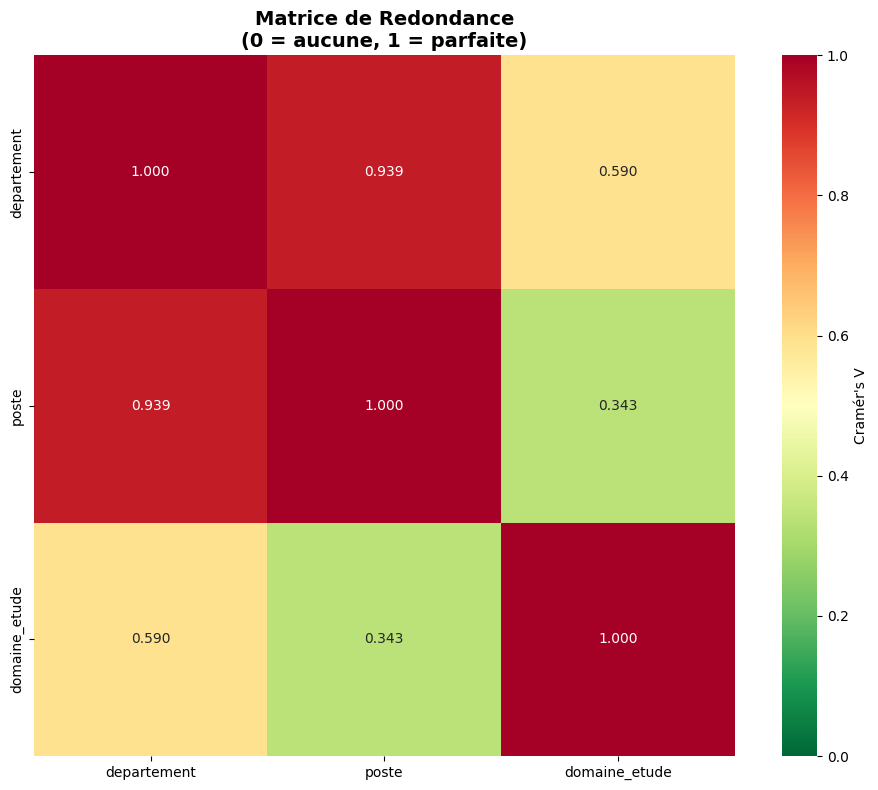

In [45]:
# Test avec vos 3 colonnes
colonnes = ['departement', 'poste', 'domaine_etude']

resultats = full_analysis(colonnes, df, plot=True)

**Résultats :**
- **Forte redondance** entre `departement` et `poste`
- **Redondance modérée** entre `departement` et `domaine_etude`
- **Aucune association** entre `poste` et `domaine_etude`


### Décision de suppression suite aux analyses
Sur la base des analyses Pearson, pairplot et Spearman, les colonnes suivantes seront supprimées :
- `niveau_hierarchique_poste` (redondante avec `revenu_mensuel`)
- `annees_dans_le_poste_actuel` (redondante avec `annees_dans_l_entreprise` et `mobilite_interne`)
- `annees_sous_responsable_actuel` (redondante avec `annees_dans_l_entreprise` et `stabilite_management`)
- `annees_depuis_la_derniere_promotion` (redondante avec `annees_dans_l_entreprise`)
- `departement` (redondante avec `poste`)

Les features `stabilite_management` et `engagement_formation` sont conservées malgré leurs corrélations Spearman avec les variables sources : elles captent un signal de ratio (intensité relative) distinct de la valeur absolue, pertinent pour la modélisation.

In [46]:
df = pp.remove_redundant_columns(df)

🗂️ Suppression de colonnes | shape initiale : (1470, 31)
✅ 3 colonnes supprimées | 0 inexistante | shape finale : (1470, 28)


In [47]:
# Configuration de l'affichage pandas
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.width', None)         # Largeur automatique
print(df.info())

df.to_csv("data/data_clean.csv", index=False)

<class 'pandas.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        1470 non-null   int64  
 1   genre                                      1470 non-null   int64  
 2   revenu_mensuel                             1470 non-null   int64  
 3   statut_marital                             1470 non-null   str    
 4   poste                                      1470 non-null   str    
 5   nombre_experiences_precedentes             1470 non-null   int64  
 6   annee_experience_totale                    1470 non-null   int64  
 7   annees_dans_le_poste_actuel                1470 non-null   int64  
 8   satisfaction_employee_environnement        1470 non-null   int64  
 9   note_evaluation_precedente                 1470 non-null   int64  
 10  satisfaction_employee_nature_travai

In [48]:
display(df.head())

,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel,mobilite_interne,age_debut_carriere,score_satisfaction_global
0,41,0,5993,Célibataire,Cadre Commercial,8,8,4,2,3,4,1,1,3,1,11,Oui,0,0,1,2,Infra & Cloud,1,0,5,2,33,2.00
1,49,1,5130,Marié(e),Assistant de Direction,1,10,7,3,2,2,4,3,4,0,23,Non,1,3,8,1,Infra & Cloud,2,1,7,3,39,3.00
2,37,1,2090,Célibataire,Consultant,6,7,0,4,2,3,2,3,3,1,15,Oui,0,3,2,2,Autre,1,0,0,0,30,3.00
3,33,0,2909,Marié(e),Assistant de Direction,1,8,7,4,3,3,3,3,3,1,11,Non,0,3,3,4,Infra & Cloud,2,3,0,1,25,3.25
4,27,1,3468,Marié(e),Consultant,9,6,2,1,3,2,4,3,3,0,12,Non,1,3,2,1,Transformation Digitale,1,2,2,0,21,2.50


### Prétraitement des données

`X` regroupe l'ensemble des features

`y` correspond à la variable cible `a_quitte_l_entreprise`.

Avant l'entraînement du modèle, un prétraitement est nécessaire afin de rendre les données exploitables efficacement.

- **ColumnTransformer** : permet d'appliquer des transformations différentes selon les types de variables :
  - **Variables numériques continues** → `StandardScaler` (centrage-réduction par z-score)
  - **Variables binaires/ordinales** (`genre`, `heure_supplementaires`, `frequence_deplacement`) → `passthrough` (conservées telles quelles)
  - **Variables catégorielles** → `OneHotEncoder`

Cette séparation évite de scaler les variables binaires (0/1), ce qui n'a pas de sens statistique et compliquerait l'interprétation des coefficients.

Ces transformations seront intégrées dans une **Pipeline**, ce qui permet de chaîner le prétraitement et l'estimateur final au sein d'un même objet. Cette approche garantit que chaque transformation est apprise exclusivement à partir des données d'entraînement, évitant toute fuite d'information (*data leakage*), notamment lors de la validation croisée.




In [49]:
X, y, preprocessor = pp.prepare_ml_data(
    df,
    target=TARGET,
    binary_ordinal_features=['genre', 'heure_supplementaires', 'frequence_deplacement']
)


print(f"X : {X.shape}")
print(f"y : {y.shape}")

display(X.head())

X_transformed = preprocessor.fit_transform(X)
print(f"X transformé : {X_transformed.shape}")

X : (1470, 27)
y : (1470,)


,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annees_sous_responsable_actuel,mobilite_interne,age_debut_carriere,score_satisfaction_global
0,41,0,5993,Célibataire,Cadre Commercial,8,8,4,2,3,4,1,1,3,1,11,0,0,1,2,Infra & Cloud,1,0,5,2,33,2.00
1,49,1,5130,Marié(e),Assistant de Direction,1,10,7,3,2,2,4,3,4,0,23,1,3,8,1,Infra & Cloud,2,1,7,3,39,3.00
2,37,1,2090,Célibataire,Consultant,6,7,0,4,2,3,2,3,3,1,15,0,3,2,2,Autre,1,0,0,0,30,3.00
3,33,0,2909,Marié(e),Assistant de Direction,1,8,7,4,3,3,3,3,3,1,11,0,3,3,4,Infra & Cloud,2,3,0,1,25,3.25
4,27,1,3468,Marié(e),Consultant,9,6,2,1,3,2,4,3,3,0,12,1,3,2,1,Transformation Digitale,1,2,2,0,21,2.50


X transformé : (1470, 39)
